In [1]:
from polarization_stuff import *
from pixell import enmap
from symlens import utils
from symlens import qe
from symlens import factorize as fac
from pixell import enplot
import h5py
from numpy.random import rand
from pixell.reproject import thumbnails
from pixell import reproject
enmap.mute["polconv_fix"] = True
from sympy import Matrix, matrix_multiply_elementwise, Trace
from sympy.utilities.lambdify import implemented_function

# fix CEE < 0 (due to some dumb interpolation issue)
l = np.arange(0,15315)
EE = cmb.funlensedEE(l)
I = np.where(EE < 0)
EE[I] = 0
cmb.funlensedEE = interp1d(l,EE,bounds_error=False,fill_value=0)

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [3]:
def do_stuff(theta):
    l = np.array([np.cos(theta),np.sin(theta)]) * 3000
    L = np.array([100,0])

    sin2 = np.sin(2*(get_angle(l) - get_angle(L-l)))
    cos = np.cos(get_angle(l)-get_angle(L))
    return sin2**2 * cos

In [11]:
thetas = np.linspace(0,2*np.pi,900)

xxx = [do_stuff(t) for t in thetas]

np.sum(xxx) * (thetas[1]-thetas[0])

0.00023245199963600846

# Code to create cutouts

In [2]:
# load the foreground map
fname = 'map_car_0.5arcmin_f153.0.fits'
full_map = enmap.read_map(fname)
full_map_1res = enmap.downgrade(full_map,2) # downgrade to 1 arcmin resolution

In [3]:
# some code to make cutouts
def rotate_QU_EB(cutout_Q,cutout_U,reverse=False):
    cutout_Q, cutout_U = enmap.fft(cutout_Q), enmap.fft(cutout_U)
    Minv = -1*enmap.queb_rotmat(cutout_Q.lmap())
    Minv = np.swapaxes(Minv,0,2)
    Minv = np.swapaxes(Minv,1,3)
    if reverse: M = Minv
    else: M = np.linalg.inv(Minv)
    cutouts_QU = np.array([cutout_Q , cutout_U])
    cutouts_QU = np.swapaxes(cutouts_QU,0,1)
    cutouts_QU = np.swapaxes(cutouts_QU,1,2)
    tmp = np.zeros((cutout_Q.shape[0],cutout_Q.shape[1],2,2)) * (1+0.j)
    tmp[:,:,:,0] = cutouts_QU
    cutouts_EB = np.matmul(M,tmp)[:,:,:,0]
    cutout_E = enmap.ndmap(cutouts_EB[:,:,0],cutout_Q.wcs)
    cutout_B = enmap.ndmap(cutouts_EB[:,:,1],cutout_Q.wcs)
    return enmap.ifft(cutout_E).real,enmap.ifft(cutout_B).real

def foreground_cutouts(dec,ra,width,fluxcut=3):
    # get a X sq deg cutout
    dec,ra = np.deg2rad([dec,ra])
    width = np.deg2rad(width)
    box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
    cutout = full_map_1res.submap(box) 
    # mask sources brighter than X mJy
    cutout_mJy = 1e3 * cutout * cutout.pixsizemap()
    I = np.where(cutout_mJy > fluxcut)
    cutout[I] = 0
    # convert to muK
    cutout_T = 0.002542 * cutout.copy()
    # make Q,U maps
    p = 0.03 # constant polarization fraction 
    psi_rand = rand(cutout.shape[0],cutout.shape[1]) * np.pi # random polarization angles
    cutout_Q = cutout_T * p * np.cos(2*psi_rand)
    cutout_U = cutout_T * p * np.sin(2*psi_rand)
    # rotate to E,B
    cutout_E,cutout_B = rotate_QU_EB(cutout_Q,cutout_U)
    # create "Gaussian" versions of the foreground maps
    sT,sE,sB = np.asarray(cutout_T), np.asarray(cutout_E), np.asarray(cutout_B)
    n =  cutout.shape[0]
    baseMap = FlatMap(nX=n, nY=n, sizeX=width*np.pi/180., sizeY=width*np.pi/180.)
    sTF,sEF,sBF = baseMap.fourier(sT), baseMap.fourier(sE), baseMap.fourier(sB)
    random_phases = np.exp(1j*np.random.rand(sTF.shape[0],sTF.shape[1])*2*np.pi)
    sTF *= random_phases ; sEF *= random_phases ; sBF *= random_phases
    sTg = baseMap.inverseFourier(sTF)
    sEg = baseMap.inverseFourier(sEF)
    sBg = baseMap.inverseFourier(sBF)
    cutout_Tg = enmap.ndmap(sTg,cutout.wcs)
    cutout_Eg = enmap.ndmap(sEg,cutout.wcs)
    cutout_Bg = enmap.ndmap(sBg,cutout.wcs)
    return cutout_T,cutout_E,cutout_B,cutout_Tg,cutout_Eg,cutout_Bg

def CMB_cutouts(reference_cutout,width):
    n =  reference_cutout.shape[0]
    baseMap = FlatMap(nX=n, nY=n, sizeX=width*np.pi/180., sizeY=width*np.pi/180.)
    # Generate unlensed T,E,B cmb maps (some GRFs)
    T0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
    E0Fourier = baseMap.genGRF(cmb.funlensedEE, test=False)
    B0Fourier = 0 * E0Fourier.copy()
    # Fourier -> real space
    T0 = enmap.ndmap(baseMap.inverseFourier(T0Fourier),reference_cutout.wcs)
    E0 = enmap.ndmap(baseMap.inverseFourier(E0Fourier),reference_cutout.wcs)
    B0 = enmap.ndmap(baseMap.inverseFourier(B0Fourier),reference_cutout.wcs)
    # EB -> QU
    Q0,U0 = rotate_QU_EB(E0,B0,reverse=True)
    # load the relevant CMB convergence cutout
    kapheal = reproject.enmap_from_healpix('kap.fits',reference_cutout.shape,
                                         reference_cutout.wcs,lmax=10000,rot='gal,gal')
    kappa = enmap.ndmap(kapheal[0,:,:],reference_cutout.wcs)
    kappaFourier = baseMap.fourier(np.asarray(kappa))
    # lensed to first order
    T1_ = baseMap.doLensingTaylor(unlensed=np.asarray(T0),kappaFourier=kappaFourier,order=1)
    T1 = enmap.ndmap(T1_,reference_cutout.wcs) - T0
    Q1_ = baseMap.doLensingTaylor(unlensed=np.asarray(Q0),kappaFourier=kappaFourier,order=1)
    Q1 = enmap.ndmap(Q1_,reference_cutout.wcs) - Q0
    U1_ = baseMap.doLensingTaylor(unlensed=np.asarray(U0),kappaFourier=kappaFourier,order=1)
    U1 = enmap.ndmap(U1_,reference_cutout.wcs) - U0
    # QU -> EB
    E1,B1 = rotate_QU_EB(Q1,U1)
    return kappa,T0,E0,B0,T1,E1,B1

# Some code to get noise curves

In [4]:
#sT,_,_,_,_,_ = foreground_cutouts(0,0,15)
sT,_,_,_,_,_ = foreground_cutouts(0,0,25)
shape,wcs = sT.shape,sT.wcs

modlmap = enmap.modlmap(shape,wcs)

ellmin = 30
tellmax = 3500
pellmax = 5000
Tmask = utils.mask_kspace(shape,wcs,lmin=ellmin,lmax=tellmax)
Pmask = utils.mask_kspace(shape,wcs,lmin=ellmin,lmax=pellmax)

bin_edges = np.linspace(1,6900,500)
binner = utils.bin2D(modlmap,bin_edges)
Acorr = enmap.pixsize(shape,wcs)**0.5 / (np.prod(shape[-2:])**0.5) # area correction factor

cos2Ll1 = 2 * (fac.Ldl1 / fac.l1 / fac.L)**2 - 1
cos2Ll2 = 2 * (fac.Ldl2 / fac.l2 / fac.L)**2 - 1
sin2Ll1 = 2 * (fac.Ldl1 / fac.l1 / fac.L) * (fac.Lxl1 / fac.l1 / fac.L)
sin2Ll2 = 2 * (fac.Ldl2 / fac.l2 / fac.L) * (fac.Lxl2 / fac.l2 / fac.L)

In [5]:
feed_dict = {}
ells = np.linspace(1e-10,10000,10000)

# lensed power spectra
feed_dict['uC_T_T'] = cmb.flensedTT(modlmap)
feed_dict['uC_T_E'] = cmb.flensedTE(modlmap)
feed_dict['uC_E_E'] = cmb.flensedEE(modlmap)
feed_dict['uC_B_B'] = cmb.flensedBB(modlmap)

# derivatives of lensed power spectra (for LLS)
cltt = cmb.flensedTT(ells)
clte = cmb.flensedTE(ells)
clee = cmb.flensedEE(ells)
feed_dict['dCdlnl_T_T'] = interp1d(ells,np.gradient(cltt,np.log(ells)),bounds_error=False,fill_value=0)(modlmap)
feed_dict['dCdlnl_T_E'] = interp1d(ells,np.gradient(clte,np.log(ells)),bounds_error=False,fill_value=0)(modlmap)
feed_dict['dCdlnl_E_E'] = interp1d(ells,np.gradient(clee,np.log(ells)),bounds_error=False,fill_value=0)(modlmap)

# total power spectra
feed_dict['tC_T_T'] = Ctt_(modlmap)
feed_dict['tC_T_E'] = Cte_(modlmap)
feed_dict['tC_T_B'] = C00_(modlmap)
feed_dict['tC_E_E'] = Cee_(modlmap)
feed_dict['tC_E_B'] = C00_(modlmap)
feed_dict['tC_B_B'] = Cbb_(modlmap)

# masks
feed_dict['Tmask'] = Tmask
feed_dict['Pmask'] = Pmask

# inverse covariance
feed_dict['tCinv_T_T'] = CCinv_(modlmap)[:,:,0,0]
feed_dict['tCinv_T_E'] = CCinv_(modlmap)[:,:,0,1]
feed_dict['tCinv_T_B'] = CCinv_(modlmap)[:,:,0,2]
feed_dict['tCinv_E_E'] = CCinv_(modlmap)[:,:,1,1]
feed_dict['tCinv_E_B'] = CCinv_(modlmap)[:,:,1,2]
feed_dict['tCinv_B_B'] = CCinv_(modlmap)[:,:,2,2]

In [6]:
def swap_12(expr):
    result = expr.copy()
    keys = np.array(list(feed_dict.keys()))
    for key in keys:
        result = result.subs(key+'_l1',key+'_l3')
        result = result.subs(key+'_l2',key+'_l1')
        result = result.subs(key+'_l3',key+'_l2')
    result = result.subs('l1x','l3x')
    result = result.subs('l2x','l1x')
    result = result.subs('l3x','l2x')
    #
    result = result.subs('l1y','l3y')
    result = result.subs('l2y','l1y') 
    result = result.subs('l3y','l2y')
    #
    result = result.subs('l1','l3')
    result = result.subs('l2','l1')
    result = result.subs('l3','l2')
    return result

In [7]:
## Linear lensing responses
fTT = (fac.Ldl1 * fac.e('uC_T_T_l1') + fac.Ldl2 * fac.e('uC_T_T_l2')) * 2/fac.L**2
fTE = (fac.Ldl1 * fac.e('uC_T_E_l1') * fac.cos2t12 + fac.Ldl2 * fac.e('uC_T_E_l2')) * 2/fac.L**2
fTB = (fac.Ldl1 * fac.e('uC_T_E_l1') * fac.sin2t12) * 2 / fac.L**2
fEE = (fac.Ldl1 * fac.e('uC_E_E_l1') + fac.Ldl2 * fac.e('uC_E_E_l2')) * 2 * fac.cos2t12/fac.L**2
fEB = (fac.Ldl1 * fac.e('uC_E_E_l1') * fac.sin2t12) * 2 / fac.L**2

## Linear foreground responses
A = 1; B = 1; C = 1
gTTT = A ; gTTE = 0 ; gTTB = 0
gTET = 0 ; gTEE = B*cos2Ll2 ; gTEB = -B*sin2Ll2
gTBT = 0 ; gTBE = B*sin2Ll2 ; gTBB = B*cos2Ll2
gEET = C*fac.cos2t12 ; gEEE = 0 ; gEEB = 0
gEBT = C*fac.sin2t12 ; gEBE = 0 ; gEBB = 0
gBBT = C*fac.cos2t12 ; gBBE = 0 ; gBBB = 0

In [8]:
## MV kappa weights
FQE_TT = fTT / 2 / fac.e('tC_T_T_l1') / fac.e('tC_T_T_l2')
FQE_TE = fTE / fac.e('tC_T_T_l1') / fac.e('tC_E_E_l2')
FQE_TB = fTB / fac.e('tC_T_T_l1') / fac.e('tC_B_B_l2')
FQE_EE = fEE / 2 / fac.e('tC_E_E_l1') / fac.e('tC_E_E_l2')
FQE_EB = fEB / fac.e('tC_E_E_l1') / fac.e('tC_B_B_l2')

## LLS kappa weights
FLLS_TT = fac.e('dCdlnl_T_T_l1') * cos2Ll1 / 2 / fac.e('tC_T_T_l1')**2
FLLS_TE = (2 * fac.e('uC_T_E_l1') + fac.e('dCdlnl_T_E_l1')) / fac.e('tC_T_T_l1') / fac.e('tC_E_E_l1')
FLLS_EE = fac.e('dCdlnl_E_E_l1') * cos2Ll1 / 2 / fac.e('tC_E_E_l1')**2

## MV foreground weights
# TT
invarTT = 1 / 2 / fac.e('tC_T_T_l1') / fac.e('tC_T_T_l2')
G_TTT = gTTT * invarTT ; G_TTE = gTTE * invarTT ; G_TTB = gTTB * invarTT
# TE
invarTE = 1 / fac.e('tC_T_T_l1') / fac.e('tC_E_E_l2')
G_TET = gTET * invarTE ; G_TEE = gTEE * invarTE ; G_TEB = gTEB * invarTE
# TB
invarTB = 1 / fac.e('tC_T_T_l1') / fac.e('tC_B_B_l2')
G_TBT = gTBT * invarTB ; G_TBE = gTBE * invarTB ; G_TBB = gTBB * invarTB
# EE
invarEE = 1 / 2 / fac.e('tC_E_E_l1') / fac.e('tC_E_E_l2')
G_EET = gEET * invarEE ; G_EEE = gEEE * invarEE ; G_EEB = gEEB * invarEE
# EB
invarEB = 1 / fac.e('tC_E_E_l1') / fac.e('tC_B_B_l2')
G_EBT = gEBT * invarEB ; G_EBE = gEBE * invarEB ; G_EBB = gEBB * invarEB
# BB
invarBB = 1 / 2 / fac.e('tC_B_B_l1') / fac.e('tC_B_B_l2')
G_BBT = gBBT * invarBB ; G_BBE = gBBE * invarBB ; G_BBB = gBBB * invarBB

In [9]:
def get_norm_XY(f,F,xmask,ymask):
    integrand = f*F
    result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=xmask,ymask=ymask,physical_units=False).real
    L,rrr = binner.bin(Acorr*result)
    return L,1/rrr

def get_nonnorm_noise_XY(F,X,Y,xmask,ymask):
    Fr = swap_12(F)
    CXXl1 = fac.e('tC_'+X+'_'+X+'_l1')
    CYYl2 = fac.e('tC_'+Y+'_'+Y+'_l2')
    CXYl1 = fac.e('tC_'+X+'_'+Y+'_l1')
    CXYl2 = fac.e('tC_'+X+'_'+Y+'_l2')
    integrand = F**2*CXXl1*CYYl2
    result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=xmask,ymask=ymask,physical_units=False).real
    integrand2 = F*Fr*CXYl1*CXYl2
    xymask = xmask*ymask
    result += fac.integrate(shape,wcs,feed_dict,integrand2,xmask=xymask,ymask=xymask,physical_units=False).real
    return binner.bin(Acorr*result)

def get_nonnorm_response_XY(f,F,xmask,ymask):
    integrand = f*F
    result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=xmask,ymask=ymask,physical_units=False).real
    result *= Acorr
    return binner.bin(result)[1]

In [10]:
# MV kappa noise curves = norms
L,NormQE_TT = get_norm_XY(fTT,FQE_TT,Tmask,Tmask)
L,NormQE_TE = get_norm_XY(fTE,FQE_TE,Tmask,Pmask)
L,NormQE_TB = get_norm_XY(fTB,FQE_TB,Tmask,Pmask)
L,NormQE_EE = get_norm_XY(fEE,FQE_EE,Pmask,Pmask)
L,NormQE_EB = get_norm_XY(fEB,FQE_EB,Pmask,Pmask)

# MV foreground norms
# ST estimators
L,NormST_TT = get_norm_XY(gTTT,G_TTT,Tmask,Tmask)
L,NormST_EE = get_norm_XY(gEET,G_EET,Pmask,Pmask)
L,NormST_EB = get_norm_XY(gEBT,G_EBT,Pmask,Pmask)
L,NormST_BB = get_norm_XY(gBBT,G_BBT,Pmask,Pmask)
# SE estimators
L,NormSE_TE = get_norm_XY(gTEE,G_TEE,Tmask,Pmask)
L,NormSE_TB = get_norm_XY(gTBE,G_TBE,Tmask,Pmask)
# SB estimators
L,NormSB_TE = get_norm_XY(gTEB,G_TEB,Tmask,Pmask)
L,NormSB_TB = get_norm_XY(gTBB,G_TBB,Tmask,Pmask)

In [11]:
# LLS norms != noise
L,NormLLS_TT = get_norm_XY(fTT,FLLS_TT,Tmask,Tmask)
L,NormLLS_TE = get_norm_XY(fTE,FLLS_TE,Tmask,Pmask)
L,NormLLS_EE = get_norm_XY(fEE,FLLS_EE,Pmask,Pmask)
# LLS nonnorm noise curves
L,ucNoiseLLS_TT = get_nonnorm_noise_XY(FLLS_TT,'T','T',Tmask,Tmask)
L,ucNoiseLLS_TE = get_nonnorm_noise_XY(FLLS_TE,'T','E',Tmask,Pmask)
L,ucNoiseLLS_EE = get_nonnorm_noise_XY(FLLS_EE,'E','E',Pmask,Pmask)

In [12]:
# lensing response to foregrounds
# TT
RkTT_T = NormQE_TT*get_nonnorm_response_XY(gTTT,FQE_TT,Tmask,Tmask)
RkTT_E = RkTT_T*0 ; RkTT_B = RkTT_T*0
# TE
RkTE_E = NormQE_TE*get_nonnorm_response_XY(gTEE,FQE_TE,Tmask,Pmask)
RkTE_B = NormQE_TE*get_nonnorm_response_XY(gTEB,FQE_TE,Tmask,Pmask)
RkTE_T = RkTE_E*0
# TB
RkTB_E = NormQE_TB*get_nonnorm_response_XY(gTBE,FQE_TB,Tmask,Pmask)
RkTB_B = NormQE_TB*get_nonnorm_response_XY(gTBB,FQE_TB,Tmask,Pmask)
RkTB_T = RkTB_E*0
# EE
RkEE_T = NormQE_EE*get_nonnorm_response_XY(gEET,FQE_EE,Pmask,Pmask)
RkEE_E = RkEE_T*0 ; RkEE_B = RkEE_T*0
# EB
RkEB_T = NormQE_EB*get_nonnorm_response_XY(gEBT,FQE_EB,Pmask,Pmask)
RkEB_E = RkEB_T*0 ; RkEB_B = RkEB_T*0
# BB
RkBB_T = RkEB_T*0 ; RkBB_E = RkEB_T*0 ; RkBB_B = RkEB_T*0

In [13]:
# foreground response to lensing
# TT
RsTTT_k = NormST_TT*get_nonnorm_response_XY(fTT,G_TTT,Tmask,Tmask)
RsETT_k = 0*RsTTT_k
RsBTT_k = 0*RsTTT_k
# TE
RsTTE_k = 0*RsTTT_k
RsETE_k = NormSE_TE*get_nonnorm_response_XY(fTE,G_TEE,Tmask,Pmask) 
RsBTE_k = NormSB_TE*get_nonnorm_response_XY(fTE,G_TEB,Tmask,Pmask)
# TB
RsTTB_k = 0*RsTTT_k
RsETB_k = NormSE_TB*get_nonnorm_response_XY(fTB,G_TBE,Tmask,Pmask)  
RsBTB_k = NormSB_TB*get_nonnorm_response_XY(fTB,G_TBB,Tmask,Pmask) 
# EE
RsTEE_k = NormST_EE*get_nonnorm_response_XY(fEE,G_EET,Tmask,Tmask) 
RsEEE_k = 0*RsTTT_k
RsBEE_k = 0*RsTTT_k
# EB
RsTEB_k = NormST_EB*get_nonnorm_response_XY(fEB,G_EBT,Tmask,Tmask)  
RsEEB_k = 0*RsTTT_k 
RsBEB_k = 0*RsTTT_k
# BB
RsTBB_k = 0*RsTTT_k  
RsEBB_k = 0*RsTTT_k 
RsBBB_k = 0*RsTTT_k

In [14]:
# foreground response to ST
# TT
RsTTT_ST = NormST_TT*get_nonnorm_response_XY(gTTT,G_TTT,Tmask,Tmask)
RsETT_ST = 0*RsTTT_k
RsBTT_ST = 0*RsTTT_k
# TE
RsTTE_ST = 0*RsTTT_k
RsETE_ST = 0*RsTTT_k 
RsBTE_ST = 0*RsTTT_k
# TB
RsTTB_ST = 0*RsTTT_k
RsETB_ST = 0*RsTTT_k  
RsBTB_ST = 0*RsTTT_k
# EE
RsTEE_ST = NormST_EE*get_nonnorm_response_XY(gEET,G_EET,Pmask,Pmask) 
RsEEE_ST = 0*RsTTT_k
RsBEE_ST = 0*RsTTT_k
# EB
RsTEB_ST = NormST_EB*get_nonnorm_response_XY(gEBT,G_EBT,Pmask,Pmask)  
RsEEB_ST = 0*RsTTT_k 
RsBEB_ST = 0*RsTTT_k
# BB
RsTBB_ST = NormST_BB*get_nonnorm_response_XY(gBBT,G_BBT,Pmask,Pmask)  
RsEBB_ST = 0*RsTTT_k 
RsBBB_ST = 0*RsTTT_k

In [15]:
# foreground response to SE
# TT
RsTTT_SE = 0*RsTTT_k
RsETT_SE = 0*RsTTT_k
RsBTT_SE = 0*RsTTT_k
# TE
RsTTE_SE = 0*RsTTT_k
RsETE_SE = NormSE_TE*get_nonnorm_response_XY(gTEE,G_TEE,Tmask,Pmask) 
RsBTE_SE = NormSB_TE*get_nonnorm_response_XY(gTEE,G_TEB,Tmask,Pmask)
# TB
RsTTB_SE = 0*RsTTT_k
RsETB_SE = NormSE_TB*get_nonnorm_response_XY(gTBE,G_TBE,Tmask,Pmask) 
RsBTB_SE = NormSB_TB*get_nonnorm_response_XY(gTBE,G_TBB,Tmask,Pmask) 
# EE
RsTEE_SE = 0*RsTTT_k 
RsEEE_SE = 0*RsTTT_k
RsBEE_SE = 0*RsTTT_k
# EB
RsTEB_SE = 0*RsTTT_k  
RsEEB_SE = 0*RsTTT_k 
RsBEB_SE = 0*RsTTT_k
# BB
RsTBB_SE = 0*RsTTT_k
RsEBB_SE = 0*RsTTT_k 
RsBBB_SE = 0*RsTTT_k

In [16]:
# foreground response to SB
# TT
RsTTT_SB = 0*RsTTT_k
RsETT_SB = 0*RsTTT_k
RsBTT_SB = 0*RsTTT_k
# TE
RsTTE_SB = 0*RsTTT_k
RsETE_SB = NormSE_TE*get_nonnorm_response_XY(gTEB,G_TEE,Tmask,Pmask) 
RsBTE_SB = NormSB_TE*get_nonnorm_response_XY(gTEB,G_TEB,Tmask,Pmask)
# TB
RsTTB_SB = 0*RsTTT_k
RsETB_SB = NormSE_TB*get_nonnorm_response_XY(gTBB,G_TBE,Tmask,Pmask) 
RsBTB_SB = NormSB_TB*get_nonnorm_response_XY(gTBB,G_TBB,Tmask,Pmask) 
# EE
RsTEE_SB = 0*RsTTT_k 
RsEEE_SB = 0*RsTTT_k
RsBEE_SB = 0*RsTTT_k
# EB
RsTEB_SB = 0*RsTTT_k  
RsEEB_SB = 0*RsTTT_k 
RsBEB_SB = 0*RsTTT_k
# BB
RsTBB_SB = 0*RsTTT_k
RsEBB_SB = 0*RsTTT_k 
RsBBB_SB = 0*RsTTT_k

In [17]:
# bias hardening matrices
ONE = np.ones(RkTT_T.shape)

MTT = np.array([[ONE    , RkTT_T  , RkTT_E  , RkTT_B  ],
                [RsTTT_k, ONE     , RsTTT_SE, RsTTT_SB],
                [RsETT_k, RsETT_ST, ONE     , RsETT_SB],
                [RsBTT_k, RsBTT_ST, RsBTT_SE, ONE     ]])

MTE = np.array([[ONE    , RkTE_T  , RkTE_E  , RkTE_B  ],
                [RsTTE_k, ONE     , RsTTE_SE, RsTTE_SB],
                [RsETE_k, RsETE_ST, ONE     , RsETE_SB],
                [RsBTE_k, RsBTE_ST, RsBTE_SE, ONE     ]])

MTB = np.array([[ONE    , RkTB_T  , RkTB_E  , RkTB_B  ],
                [RsTTB_k, ONE     , RsTTB_SE, RsTTB_SB],
                [RsETB_k, RsETB_ST, ONE     , RsETB_SB],
                [RsBTB_k, RsBTB_ST, RsBTB_SE, ONE     ]])

MEE = np.array([[ONE    , RkEE_T  , RkEE_E  , RkEE_B  ],
                [RsTEE_k, ONE     , RsTEE_SE, RsTEE_SB],
                [RsEEE_k, RsEEE_ST, ONE     , RsEEE_SB],
                [RsBEE_k, RsBEE_ST, RsBEE_SE, ONE     ]])

MEB = np.array([[ONE    , RkEB_T  , RkEB_E  , RkEB_B  ],
                [RsTEB_k, ONE     , RsTEB_SE, RsTEB_SB],
                [RsEEB_k, RsEEB_ST, ONE     , RsEEB_SB],
                [RsBEB_k, RsBEB_ST, RsBEB_SE, ONE     ]])

MTT = np.swapaxes(MTT,0,2) ; MTT = np.swapaxes(MTT,1,2)
MTE = np.swapaxes(MTE,0,2) ; MTE = np.swapaxes(MTE,1,2)
MTB = np.swapaxes(MTB,0,2) ; MTB = np.swapaxes(MTB,1,2)
MEE = np.swapaxes(MEE,0,2) ; MEE = np.swapaxes(MEE,1,2)
MEB = np.swapaxes(MEB,0,2) ; MEB = np.swapaxes(MEB,1,2)

In [18]:
# analytic noise cost
NC_TT = np.linalg.det(MTT[:,1:,1:])/np.linalg.det(MTT)
NC_TE = np.linalg.det(MTE[:,1:,1:])/np.linalg.det(MTE)
NC_TB = np.linalg.det(MTB[:,1:,1:])/np.linalg.det(MTB)
NC_EE = np.linalg.det(MEE[:,1:,1:])/np.linalg.det(MEE)
NC_EB = np.linalg.det(MEB[:,1:,1:])/np.linalg.det(MEB)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


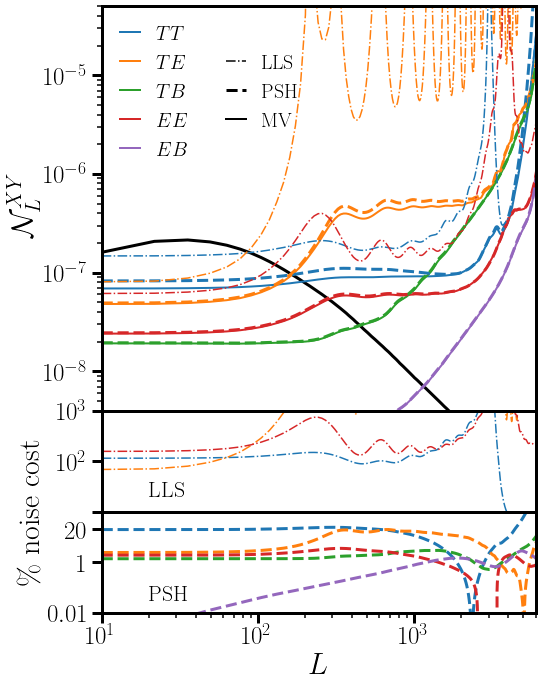

In [19]:
fig,ax = plt.subplots(3,1,figsize=(8,10),sharex=True,gridspec_kw={'height_ratios': [8, 2, 2],'hspace':0})

ax[0].loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=3)

ax[0].loglog(L,NormQE_TT,lw=2,c='C0',label=r'$TT$')
ax[0].loglog(L,NormQE_TE,lw=2,c='C1',label=r'$TE$')
ax[0].loglog(L,NormQE_TB,lw=2,c='C2',label=r'$TB$')
ax[0].loglog(L,NormQE_EE,lw=2,c='C3',label=r'$EE$')
ax[0].loglog(L,NormQE_EB,lw=2,c='C4',label=r'$EB$')

ax[0].loglog(L,NormQE_TT*NC_TT,lw=3,ls='--',c='C0')
ax[0].loglog(L,NormQE_TE*NC_TE,lw=3,ls='--',c='C1')
ax[0].loglog(L,NormQE_TB*NC_TB,lw=3,ls='--',c='C2')
ax[0].loglog(L,NormQE_EE*NC_EE,lw=3,ls='--',c='C3')
ax[0].loglog(L,NormQE_EB*NC_EB,lw=3,ls='--',c='C4')

ax[0].loglog(L,NormLLS_TT**2 * ucNoiseLLS_TT,lw=1.5,c='C0',ls='-.')
ax[0].loglog(L,NormLLS_TE**2 * ucNoiseLLS_TE,lw=1.5,c='C1',ls='-.')
ax[0].loglog(L,NormLLS_EE**2 * ucNoiseLLS_EE,lw=1.5,c='C3',ls='-.')

#ax[0].loglog([],[],lw=3,c='white',ls='dotted',label=r'$ $')
ax[0].loglog([],[],lw=3,c='white',ls='dotted',label=r'$ $')
ax[0].loglog([],[],lw=1.5,c='k',ls='-.',label=r'LLS')
ax[0].loglog([],[],lw=3,c='k',ls='--',label=r'PSH')
ax[0].loglog([],[],lw=2,c='k',label=r'MV')

ax[0].set_xlim(10,6000)
ax[0].set_ylim(4e-9,5e-5)
ax[0].set_ylabel(r'$\mathcal{N}^{XY}_{L}$')
ax[0].legend(loc='upper left',frameon=False,ncol=2,fontsize=20,handlelength=1)


########### second panel

ax[1].loglog(L,(NormLLS_TT**2 * ucNoiseLLS_TT / NormQE_TT-1)*100,lw=1.5,c='C0',ls='-.')
ax[1].loglog(L,(NormLLS_TE**2 * ucNoiseLLS_TE / NormQE_TE-1)*100,lw=1.5,c='C1',ls='-.')
ax[1].loglog(L,(NormLLS_EE**2 * ucNoiseLLS_EE / NormQE_EE-1)*100,lw=1.5,c='C3',ls='-.')

ax[1].set_ylim(10,1000)
ax[1].set_yticks([10,100,1000])
ax[1].set_yticklabels([r'',r'$10^2$',r'$10^3$'])
np.linalg.inv(MEE)[1][:,0]
ax[1].text(20,20,'LLS')

########## third panel

ax[2].loglog(L,(NC_TT-1)*100,lw=3,ls='--',c='C0')
ax[2].loglog(L,(NC_TE-1)*100,lw=3,ls='--',c='C1')
ax[2].loglog(L,(NC_TB-1)*100,lw=3,ls='--',c='C2')
ax[2].loglog(L,(NC_EE-1)*100,lw=3,ls='--',c='C3')
ax[2].loglog(L,(NC_EB-1)*100,lw=3,ls='--',c='C4')

ax[2].set_yticks([1e-2,1,20])
ax[2].set_yticklabels([r'$0.01$',r'$1$',r'20'])
ax[2].set_ylim(1e-2,100)

ax[2].text(20,0.03,'PSH')

ax[2].set_xlabel(r'$L$')
ax[2].set_ylabel(r'$\quad\quad\%$ noise cost')
ax[2].yaxis.set_label_coords(-0.13, 1)

##################
plt.tight_layout()
plt.savefig('noise_curves.pdf',bbox_inches='tight')

In [20]:
# coefficients for PSH (the relevant entries of the bias-hardening matrices)

## TT
MTTk = np.linalg.inv(MTT)[:,0,0] ; MTTk[0] = MTTk[1] # kappa
M_TTk = interp1d(L,MTTk,bounds_error=False,fill_value=0)

MTTT = np.linalg.inv(MTT)[:,0,1] ; MTTT[0] = MTTT[1] # sT
M_TTT = interp1d(L,MTTT,bounds_error=False,fill_value=0)

## TE
MTEk = np.linalg.inv(MTE)[:,0,0] ; MTEk[0] = MTEk[1] # kappa
M_TEk = interp1d(L,MTEk,bounds_error=False,fill_value=0)

MTEE = np.linalg.inv(MTE)[:,0,2] ; MTEE[0] = MTEE[1] # sE
M_TEE = interp1d(L,MTEE,bounds_error=False,fill_value=0)

MTEB = np.linalg.inv(MTE)[:,0,3] ; MTEB[0] = MTEB[1] # sB
M_TEB = interp1d(L,MTEB,bounds_error=False,fill_value=0)

## TB
MTBk = np.linalg.inv(MTB)[:,0,0] ; MTBk[0] = MTBk[1] # kappa
M_TBk = interp1d(L,MTBk,bounds_error=False,fill_value=0)

MTBE = np.linalg.inv(MTB)[:,0,2] ; MTBE[0] = MTBE[1] # sE
M_TBE = interp1d(L,MTBE,bounds_error=False,fill_value=0)

MTBB = np.linalg.inv(MTB)[:,0,3] ; MTBB[0] = MTBB[1] # sB
M_TBB = interp1d(L,MTBB,bounds_error=False,fill_value=0)

## EE
MEEk = np.linalg.inv(MEE)[:,0,0] ; MEEk[0] = MEEk[1] # kappa
M_EEk = interp1d(L,MEEk,bounds_error=False,fill_value=0)

MEET = np.linalg.inv(MEE)[:,0,1] ; MEET[0] = MEET[1] # sT
M_EET = interp1d(L,MEET,bounds_error=False,fill_value=0)

## EB
MEBk = np.linalg.inv(MEB)[:,0,0] ; MEBk[0] = MEBk[1] # kappa
M_EBk = interp1d(L,MEBk,bounds_error=False,fill_value=0)

MEBT = np.linalg.inv(MEB)[:,0,1] ; MEBT[0] = MEBT[1] # sT
M_EBT = interp1d(L,MEBT,bounds_error=False,fill_value=0)

In [21]:
# symbolic versions of these coefficients

# TT
smM_TTk = implemented_function('MTTk', lambda x: M_TTk(x) * interp1d(L,NormQE_TT,bounds_error=False,fill_value=0)(x)  )
smM_TTT = implemented_function('MTTT', lambda x: M_TTT(x) * interp1d(L,NormST_TT,bounds_error=False,fill_value=0)(x)  )
# TE
smM_TEk = implemented_function('MTEk', lambda x: M_TEk(x) * interp1d(L,NormQE_TE,bounds_error=False,fill_value=0)(x)  )
smM_TEE = implemented_function('MTEE', lambda x: M_TEE(x) * interp1d(L,NormSE_TE,bounds_error=False,fill_value=0)(x)  )
smM_TEB = implemented_function('MTEB', lambda x: M_TEB(x) * interp1d(L,NormSB_TE,bounds_error=False,fill_value=0)(x)  )
# TB
smM_TBk = implemented_function('MTBk', lambda x: M_TBk(x) * interp1d(L,NormQE_TB,bounds_error=False,fill_value=0)(x)  )
smM_TBE = implemented_function('MTBE', lambda x: M_TBE(x) * interp1d(L,NormSE_TB,bounds_error=False,fill_value=0)(x)  )
smM_TBB = implemented_function('MTBB', lambda x: M_TBB(x) * interp1d(L,NormSB_TB,bounds_error=False,fill_value=0)(x)  )
# EE
smM_EEk = implemented_function('MEEk', lambda x: M_EEk(x) * interp1d(L,NormQE_EE,bounds_error=False,fill_value=0)(x)  )
smM_EET = implemented_function('MEET', lambda x: M_EET(x) * interp1d(L,NormST_EE,bounds_error=False,fill_value=0)(x)  )
# EB
smM_EBk = implemented_function('MEBk', lambda x: M_EBk(x) * interp1d(L,NormQE_EB,bounds_error=False,fill_value=0)(x)  )
smM_EBT = implemented_function('MEBT', lambda x: M_EBT(x) * interp1d(L,NormST_EB,bounds_error=False,fill_value=0)(x)  )

# symbolic point-source hardened weights (not correctly normalized, but that doesn't matter)

FPSH_TT = smM_TTk(fac.L) * FQE_TT + smM_TTT(fac.L) * G_TTT
FPSH_TE = smM_TEk(fac.L) * FQE_TE + smM_TEE(fac.L) * G_TEE + smM_TEB(fac.L) * G_TEB
FPSH_TB = smM_TBk(fac.L) * FQE_TB + smM_TBE(fac.L) * G_TBE + smM_TBB(fac.L) * G_TBB
FPSH_EE = smM_EEk(fac.L) * FQE_EE + smM_EET(fac.L) * G_EET
FPSH_EB = smM_EBk(fac.L) * FQE_EB + smM_EBT(fac.L) * G_EBT

In [22]:
# PSH kappa norms != noise
L,NormPSH_TT = get_norm_XY(fTT,FPSH_TT,Tmask,Tmask)
L,NormPSH_TE = get_norm_XY(fTE,FPSH_TE,Tmask,Pmask)
L,NormPSH_TB = get_norm_XY(fTB,FPSH_TB,Tmask,Pmask)
L,NormPSH_EE = get_norm_XY(fEE,FPSH_EE,Pmask,Pmask)
L,NormPSH_EB = get_norm_XY(fEB,FPSH_EB,Pmask,Pmask)

# Noise curves for combined estimators

In [25]:
def get_nonnorm_NXYMN(Fxy,Fmn,X,Y,M,N,xmask,ymask,mmask,nmask):
    Fmnr = swap_12(Fmn)
    Cxml1 = fac.e('tC_'+X+'_'+M+'_l1')
    Cynl2 = fac.e('tC_'+Y+'_'+N+'_l2')
    Cxnl1 = fac.e('tC_'+X+'_'+N+'_l1')
    Cyml2 = fac.e('tC_'+Y+'_'+M+'_l2')
    integrand1 = Fxy*Fmn*Cxml1*Cynl2
    xmmask = xmask*mmask
    ynmask = ymask*nmask
    result = fac.integrate(shape,wcs,feed_dict,integrand1,xmask=xmmask,ymask=ynmask,physical_units=False).real
    #
    integrand2 = Fxy*Fmnr*Cxnl1*Cyml2
    xnmask = xmask*nmask
    ymmask = ymask*mmask
    result += fac.integrate(shape,wcs,feed_dict,integrand2,xmask=xnmask,ymask=ymmask,physical_units=False).real
    return binner.bin(Acorr*result)[1]

In [23]:
# some code for getting the "local" minimum variance combination
weight_pairs = [FQE_TT,FQE_TE,FQE_TB,FQE_EE,FQE_EB]
name_pairs = [['T','T'],['T','E'],['T','B'],['E','E'],['E','B']]
mask_pairs = [[Tmask,Tmask],[Tmask,Pmask],[Tmask,Pmask],[Pmask,Pmask],[Pmask,Pmask]]
norm_pairs = [NormQE_TT,NormQE_TE,NormQE_TB,NormQE_EE,NormQE_EB]

LENGTH = len(weight_pairs)

NTEB = np.zeros((LENGTH,LENGTH,len(NormQE_TT)))

for i in range(5):
    for j in range(i,5):
        print(i,j, end="\r")
        X,Y = name_pairs[i]
        M,N = name_pairs[j]
        Xmask,Ymask = mask_pairs[i]
        Mmask,Nmask = mask_pairs[j]
        Fxy,Fmn = weight_pairs[i],weight_pairs[j]
        NTEB[i,j,:] = get_nonnorm_NXYMN(Fxy,Fmn,X,Y,M,N,Xmask,Ymask,Mmask,Nmask)
        NTEB[i,j,:] *= norm_pairs[i] * norm_pairs[j]
        NTEB[j,i,:] = NTEB[i,j,:]
NTEB = np.swapaxes(NTEB,0,2)

Cinv = np.linalg.inv(NTEB)
ONE = np.ones(Cinv.shape[-1])
noise_all = 1/np.dot(np.dot(ONE,Cinv),ONE)

/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [24]:
norm = np.dot(np.dot(Cinv,ONE),ONE)
weights = interp1d(L,np.nan_to_num(np.swapaxes(np.dot(Cinv,ONE),0,1) / norm))

NameError: name 'Cinv' is not defined

In [26]:
# some code for getting the "local" minimum variance combination
weight_pairs = [FPSH_TT,FPSH_TE,FPSH_TB,FPSH_EE,FPSH_EB]
name_pairs = [['T','T'],['T','E'],['T','B'],['E','E'],['E','B']]
mask_pairs = [[Tmask,Tmask],[Tmask,Pmask],[Tmask,Pmask],[Pmask,Pmask],[Pmask,Pmask]]
norm_pairs = [NormPSH_TT,NormPSH_TE,NormPSH_TB,NormPSH_EE,NormPSH_EB]

LENGTH = len(weight_pairs)

NTEB = np.zeros((LENGTH,LENGTH,len(NormQE_TT)))

for i in range(5):
    for j in range(i,5):
        print(i,j, end="\r")
        X,Y = name_pairs[i]
        M,N = name_pairs[j]
        Xmask,Ymask = mask_pairs[i]
        Mmask,Nmask = mask_pairs[j]
        Fxy,Fmn = weight_pairs[i],weight_pairs[j]
        NTEB[i,j,:] = get_nonnorm_NXYMN(Fxy,Fmn,X,Y,M,N,Xmask,Ymask,Mmask,Nmask)
        NTEB[i,j,:] *= norm_pairs[i] * norm_pairs[j]
        NTEB[j,i,:] = NTEB[i,j,:]
NTEB = np.swapaxes(NTEB,0,2)

Cinv_psh = np.linalg.inv(NTEB)
ONE = np.ones(Cinv_psh.shape[-1])
noise_PSH_all = 1/np.dot(np.dot(ONE,Cinv_psh),ONE)

In [27]:
norm = np.dot(np.dot(Cinv_psh,ONE),ONE)
weights_psh = interp1d(L,np.nan_to_num(np.swapaxes(np.dot(Cinv_psh,ONE),0,1) / norm))

In [25]:
# some code for getting the "local" minimum variance combination
weight_pairs = [FLLS_TT,FLLS_TE,FLLS_EE,FQE_EB]
name_pairs = [['T','T'],['T','E'],['E','E'],['E','B']]
mask_pairs = [[Tmask,Tmask],[Tmask,Pmask],[Pmask,Pmask],[Pmask,Pmask]]
norm_pairs = [NormLLS_TT,NormLLS_TE,NormLLS_EE,NormQE_EB]

LENGTH = len(weight_pairs)

NTEB = np.zeros((LENGTH,LENGTH,len(NormQE_TT)))

for i in range(4):
    for j in range(i,4):
        print(i,j, end="\r")
        X,Y = name_pairs[i]
        M,N = name_pairs[j]
        Xmask,Ymask = mask_pairs[i]
        Mmask,Nmask = mask_pairs[j]
        Fxy,Fmn = weight_pairs[i],weight_pairs[j]
        NTEB[i,j,:] = get_nonnorm_NXYMN(Fxy,Fmn,X,Y,M,N,Xmask,Ymask,Mmask,Nmask)
        NTEB[i,j,:] *= norm_pairs[i] * norm_pairs[j]
        NTEB[j,i,:] = NTEB[i,j,:]
NTEB = np.swapaxes(NTEB,0,2)

Cinv = np.linalg.inv(NTEB)
ONE = np.ones(Cinv.shape[-1])
noise_LLS_MVC = 1/np.dot(np.dot(ONE,Cinv),ONE)

In [31]:
# GMV weights

f_matrix_symlens = Matrix([[fTT,fTE,fTB],
                          [swap_12(fTE),fEE,fEB],
                          [swap_12(fTB),swap_12(fEB),0]])

C_l1_inv            = Matrix([[fac.e('tCinv_T_T_l1'),fac.e('tCinv_T_E_l1'),fac.e('tCinv_T_B_l1')],
                              [fac.e('tCinv_T_E_l1'),fac.e('tCinv_E_E_l1'),fac.e('tCinv_E_B_l1')],
                              [fac.e('tCinv_T_B_l1'),fac.e('tCinv_E_B_l1'),fac.e('tCinv_B_B_l1')]])

C_l1                = Matrix([[fac.e('tC_T_T_l1'),fac.e('tC_T_E_l1'),fac.e('tC_T_B_l1')],
                              [fac.e('tC_T_E_l1'),fac.e('tC_E_E_l1'),fac.e('tC_E_B_l1')],
                              [fac.e('tC_T_B_l1'),fac.e('tC_E_B_l1'),fac.e('tC_B_B_l1')]])

C_l2_inv            = Matrix([[fac.e('tCinv_T_T_l2'),fac.e('tCinv_T_E_l2'),fac.e('tCinv_T_B_l2')],
                              [fac.e('tCinv_T_E_l2'),fac.e('tCinv_E_E_l2'),fac.e('tCinv_E_B_l2')],
                              [fac.e('tCinv_T_B_l2'),fac.e('tCinv_E_B_l2'),fac.e('tCinv_B_B_l2')]])

C_l2                = Matrix([[fac.e('tC_T_T_l2'),fac.e('tC_T_E_l2'),fac.e('tC_T_B_l2')],
                              [fac.e('tC_T_E_l2'),fac.e('tC_E_E_l2'),fac.e('tC_E_B_l2')],
                              [fac.e('tC_T_B_l2'),fac.e('tC_E_B_l2'),fac.e('tC_B_B_l2')]])

mask_matrix = Matrix([[fac.e('Tmask_l1')*fac.e('Tmask_l2'),fac.e('Tmask_l1')*fac.e('Pmask_l2'),fac.e('Tmask_l1')*fac.e('Pmask_l2')],
                      [fac.e('Pmask_l1')*fac.e('Tmask_l2'),fac.e('Pmask_l1')*fac.e('Pmask_l2'),fac.e('Pmask_l1')*fac.e('Pmask_l2')],
                      [fac.e('Pmask_l1')*fac.e('Tmask_l2'),fac.e('Pmask_l1')*fac.e('Pmask_l2'),fac.e('Pmask_l1')*fac.e('Pmask_l2')]])

F_GMV_smpy = 0.5 * C_l1_inv * f_matrix_symlens * C_l2_inv

F_GMV_smpy = matrix_multiply_elementwise(F_GMV_smpy,mask_matrix)

In [33]:
MMM = F_GMV_smpy * f_matrix_symlens.T
integrand = MMM[0,0] + MMM[1,1] + MMM[2,2]

nomask = utils.mask_kspace(shape,wcs,lmin=2,lmax=10000)
result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=nomask,ymask=nomask,physical_units=False).real
Norm_GMV_symlens = 1/binner.bin(Acorr*result)[1]

In [29]:
# GLLS weights

feed_dict['tmpfac'] = 2 * (Ctt_(modlmap)**2 * Cee_(modlmap)**2 - Cte_(modlmap)**4)
feed_dict['tmpfac2'] = Ctt_(modlmap) * Cee_(modlmap) + Cte_(modlmap)**2

Atmpfac = fac.e('tC_E_E_l1')**2 * fac.e('dCdlnl_T_T_l1') - fac.e('tC_T_E_l1')**2 * fac.e('dCdlnl_E_E_l1')
A_LLS = Atmpfac * cos2Ll1 / fac.e('tmpfac_l1')

Ctmpfac = fac.e('tC_T_T_l1')**2 * fac.e('dCdlnl_E_E_l1') - fac.e('tC_T_E_l1')**2 * fac.e('dCdlnl_T_T_l1')
C_LLS = Ctmpfac * cos2Ll1 / fac.e('tmpfac_l1')

B_LLS = (2 * fac.e('uC_T_E_l1') + fac.e('dCdlnl_T_E_l1')) / 2 / fac.e('tmpfac2_l1')

FLLS_smpy = Matrix([[A_LLS,B_LLS,0],
                    [swap_12(B_LLS),C_LLS,FQE_EB/2],
                    [0,swap_12(FQE_EB/2),0]])

FLLS_smpy = Matrix([[A_LLS,B_LLS,0],
                    [swap_12(B_LLS),C_LLS,FQE_EB/2],
                    [0,swap_12(FQE_EB/2),0]])

FLLS_smpy = matrix_multiply_elementwise(FLLS_smpy,mask_matrix)

In [30]:
MMM = FLLS_smpy * f_matrix_symlens.T
integrand = MMM[0,0] + MMM[1,1] + MMM[2,2]

nomask = utils.mask_kspace(shape,wcs,lmin=2,lmax=10000)
result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=nomask,ymask=nomask,physical_units=False).real
Norm_GMV_LLS = 1/binner.bin(Acorr*result)[1]

In [31]:
MMM = C_l1 * FLLS_smpy * C_l2 * FLLS_smpy.T
integrand = MMM[0,0] + MMM[1,1] + MMM[2,2]

nomask = utils.mask_kspace(shape,wcs,lmin=2,lmax=10000)
result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=nomask,ymask=nomask,physical_units=False).real
Noise_GMV_LLS = 2 * Norm_GMV_LLS**2 * binner.bin(Acorr*result)[1]

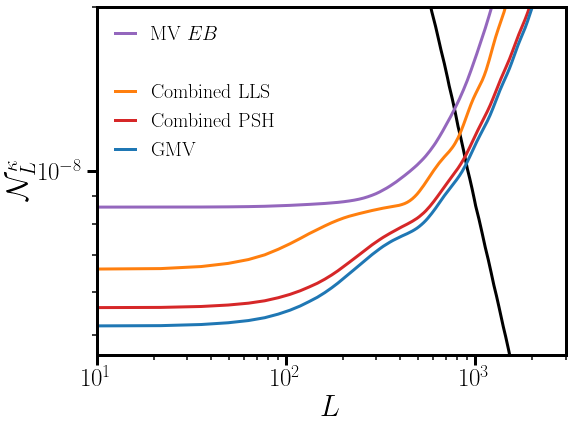

In [43]:
fig,ax = plt.subplots(1,1,figsize=(6*1.4,4*1.6))

ax.loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=3)

ax.loglog(L,NormQE_EB,lw=3,c='C4',label=r'MV $EB$')

ax.plot([],[],c='white',label=r' ')

#ax.loglog(L,Noise_GMV_LLS,lw=3,c='C1',label=r'GLLS')
ax.loglog(L,noise_LLS_MVC,lw=3,c='C1',label=r'Combined LLS')
ax.loglog(L,noise_PSH_all,lw=3,c='C3',label=r'Combined PSH')
ax.loglog(L,Norm_GMV_symlens,lw=3,c='C0',label=r'GMV')


#ax.loglog(L,noise_all,lw=3,c='C3',ls='--',label=r'MV lin. comb. of MV')

ax.legend(loc='upper left',handlelength=1,frameon=False,fontsize=20,ncol=1)
ax.set_xlim(10,3000)
ax.set_ylim(4.6e-9,2e-8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathcal{N}^\kappa_L$')
ax.set_yticks([1e-8])
ax.set_yticks([5e-9,6e-9,7e-9,8e-9,9e-9,2e-8],minor=True)
ax.set_yticklabels(['','','','','',''],minor=True)
plt.savefig('noise_curves_combined.pdf',bbox_inches='tight')

Text(0, 0.5, '$\\mathcal{N}^\\kappa_L$')

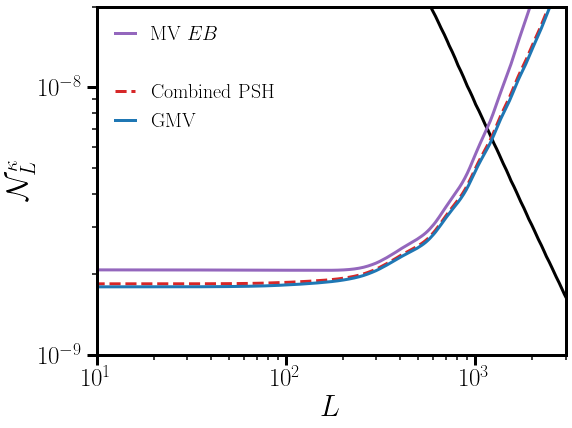

In [35]:
fig,ax = plt.subplots(1,1,figsize=(6*1.4,4*1.6))

ax.loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=3)

ax.loglog(L,NormQE_EB,lw=3,c='C4',label=r'MV $EB$')

ax.plot([],[],c='white',label=r' ')

#ax.loglog(L,noise_LLS_MVC,lw=3,c='C1',label=r'Combined LLS')
ax.loglog(L,noise_PSH_all,lw=3,c='C3',label=r'Combined PSH',ls='--')
ax.loglog(L,Norm_GMV_symlens,lw=3,c='C0',label=r'GMV')

ax.legend(loc='upper left',handlelength=1,frameon=False,fontsize=20,ncol=1)
ax.set_xlim(10,3000)
ax.set_ylim(1e-9,2e-8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathcal{N}^\kappa_L$')
#ax.set_yticks([1e-8])
#ax.set_yticks([5e-9,6e-9,7e-9,8e-9,9e-9,2e-8],minor=True)
#ax.set_yticklabels(['','','','','',''],minor=True)

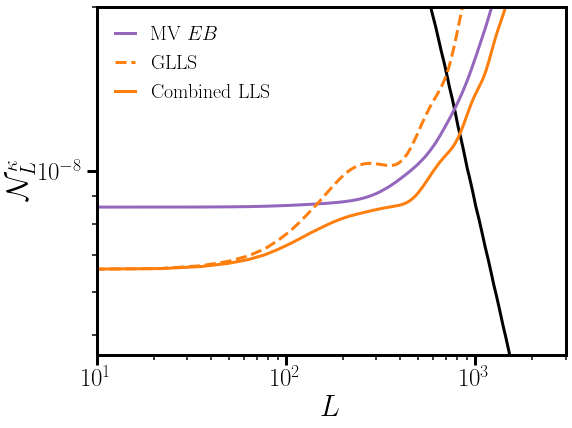

In [59]:
fig,ax = plt.subplots(1,1,figsize=(6*1.4,4*1.6))

ax.loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=3)

ax.loglog(L,NormQE_EB,lw=3,c='C4',label=r'MV $EB$')

#ax.plot([],[],c='white',label=r' ')

ax.loglog(L,Noise_GMV_LLS,lw=3,c='C1',ls='--',label=r'GLLS')
ax.loglog(L,noise_LLS_MVC,lw=3,c='C1',label=r'Combined LLS')


#ax.loglog(L,noise_all,lw=3,c='C3',ls='--',label=r'MV lin. comb. of MV')

ax.legend(loc='upper left',handlelength=1,frameon=False,fontsize=20,ncol=1)
ax.set_xlim(10,3000)
ax.set_ylim(4.6e-9,2e-8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathcal{N}^\kappa_L$')
ax.set_yticks([1e-8])
ax.set_yticks([5e-9,6e-9,7e-9,8e-9,9e-9,2e-8],minor=True)
ax.set_yticklabels(['','','','','',''],minor=True)
plt.savefig('LLS_options.pdf',bbox_inches='tight')

# Evaluate estimators to predict biases

In [27]:
# estimator
def kappa_hat(FXY,fXY,X,Y,xmask,ymask):
    XFourier = enmap.fft(X, normalize='phys')
    YFourier = enmap.fft(Y, normalize='phys')
    feed_dict['X'] = XFourier
    feed_dict['Y'] = YFourier
    nonnorm_kappa = Acorr * fac.integrate(shape,wcs,feed_dict,FXY*fac.e('X_l1')*fac.e('Y_l2'),
                                          xmask=xmask,ymask=ymask,physical_units=False)
    
    invnorm = Acorr * fac.integrate(shape,wcs,feed_dict,FXY*fXY,
                                              xmask=xmask,ymask=ymask,physical_units=False)
    invnorm[0,0] = invnorm[0,1]
    return enmap.ifft(nonnorm_kappa / invnorm / 2 / np.pi, normalize='phys').real

# complete set of things that need to be reconstructed on
def workhorse(FXY,fXY,X0,Y0,X1,Y1,sX,sY,sXg,sYg,xmask,ymask):
    a =  kappa_hat(FXY,fXY,sX,sY,xmask,ymask)
    b0 = kappa_hat(FXY,fXY,X0,sY,xmask,ymask)
    b1 = kappa_hat(FXY,fXY,X1,sY,xmask,ymask)
    c0 = kappa_hat(FXY,fXY,sX,Y0,xmask,ymask)
    c1 = kappa_hat(FXY,fXY,sX,Y1,xmask,ymask)
    d =  kappa_hat(FXY,fXY,sXg,sYg,xmask,ymask)
    return a,b0,b1,c0,c1,d

# get some power spectra
def power_spec(X,Y):
    XFourier = enmap.fft(X,normalize='phys')
    YFourier = enmap.fft(Y,normalize='phys')
    power = (XFourier*np.conj(YFourier)).real
    def bin(data,modlmap,bin_edges):
        digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
        result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
        return result
    bin_edges = np.logspace(np.log10(25),np.log10(3.5e3),9)
    centers = (bin_edges[1:] + bin_edges[:-1])/2.
    binned_power = bin(power,power.modlmap(),bin_edges)
    return centers,binned_power

# compute the biases
def primary(A,kappa): 
    return 2*power_spec(A,kappa)[1]
    
def secondary(B0,B1,C0,C1):
    result = 2*power_spec(B0,B1)[1]
    result += 2*power_spec(C0,C1)[1]
    result += 2*power_spec(B0,C1)[1]
    result += 2*power_spec(B1,C0)[1]
    return result
    
def trispectrum(A,D): 
    return power_spec(A,A)[1] - power_spec(D,D)[1]

def la_trifecta(kappa,A,B0,B1,C0,C1,D):
    return primary(A,kappa), secondary(B0,B1,C0,C1), trispectrum(A,D)

In [28]:
sT,sE,sB,sTg,sEg,sBg = foreground_cutouts(0,0,15,fluxcut=5)
kappa,T0,E0,B0,T1,E1,B1 = CMB_cutouts(sT,15) 
L,Ckk = power_spec(kappa,kappa)

Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


In [29]:
# compute the prim, sec and tri for the cross of two estimators XY and MN
def primary_XYMN(A_XY,A_MN,kappa):
    result = power_spec(A_XY,kappa)[1]
    result += power_spec(A_MN,kappa)[1]
    return result

def secondary_XYMN(B0_XY,B1_XY,C0_XY,C1_XY,B0_MN,B1_MN,C0_MN,C1_MN):
    result = power_spec(B0_XY,B1_MN)[1]
    result += power_spec(B1_XY,B0_MN)[1]
    result += power_spec(C0_XY,C1_MN)[1]
    result += power_spec(C1_XY,C0_MN)[1]
    result += power_spec(B0_XY,C1_MN)[1]
    result += power_spec(B1_XY,C0_MN)[1]
    result += power_spec(C0_XY,B1_MN)[1]
    result += power_spec(C1_XY,B0_MN)[1]
    return result

def trispectrum_XYMN(A_XY,D_XY,A_MN,D_MN):
    result = power_spec(A_XY,A_MN)[1]
    result -= power_spec(D_XY,D_MN)[1]
    return result

def total_XYMN(kappa,A_XY,B0_XY,B1_XY,C0_XY,C1_XY,D_XY,A_MN,B0_MN,B1_MN,C0_MN,C1_MN,D_MN):
    p = primary_XYMN(A_XY,A_MN,kappa)
    s = secondary_XYMN(B0_XY,B1_XY,C0_XY,C1_XY,B0_MN,B1_MN,C0_MN,C1_MN)
    t = trispectrum_XYMN(A_XY,D_XY,A_MN,D_MN)
    return p+s+t

In [30]:
def single_cutout_bias_comp(dec,ra,width,fluxcut=5):
    # load/generate cutouts
    sT,sE,sB,sTg,sEg,sBg = foreground_cutouts(dec,ra,width,fluxcut=fluxcut)
    kappa,T0,E0,B0,T1,E1,B1 = CMB_cutouts(sT,width)  
    print('Loaded cutouts')
    ######## TT
    # QE
    a_TT,b0_TT,b1_TT,c0_TT,c1_TT,d_TT = workhorse(FQE_TT,fTT,T0,T0,T1,T1,sT,sT,sTg,sTg,Tmask,Tmask)
    prim_QE_TT,sec_QE_TT,tri_QE_TT = la_trifecta(kappa,a_TT,b0_TT,b1_TT,c0_TT,c1_TT,d_TT)
    # PSH
    aT,b0T,b1T,c0T,c1T,dT = workhorse(G_TTT,gTTT,T0,T0,T1,T1,sT,sT,sTg,sTg,Tmask,Tmask)
    dolc = lambda x,xT: enmap.ifft(enmap.fft(x)*M_TTk(a_TT.modlmap()) + enmap.fft(xT)*M_TTT(a_TT.modlmap())).real
    a_TTpsh  = dolc(a_TT,aT)   ; d_TTpsh  = dolc(d_TT,dT)
    b0_TTpsh = dolc(b0_TT,b0T) ; b1_TTpsh = dolc(b1_TT,b1T)
    c0_TTpsh = dolc(c0_TT,c0T) ; c1_TTpsh = dolc(c1_TT,c1T)
    prim_PSH_TT,sec_PSH_TT,tri_PSH_TT = la_trifecta(kappa,a_TTpsh,b0_TTpsh,b1_TTpsh,c0_TTpsh,c1_TTpsh,d_TTpsh)
    # LLS
    a,b0,b1,c0,c1,d = workhorse(FLLS_TT,fTT,T0,T0,T1,T1,sT,sT,sTg,sTg,Tmask,Tmask)
    prim_LLS_TT,sec_LLS_TT,tri_LLS_TT = la_trifecta(kappa,a,b0,b1,c0,c1,d)
    #
    data_TT = [prim_QE_TT,sec_QE_TT,tri_QE_TT,
               prim_LLS_TT,sec_LLS_TT,tri_LLS_TT,
               prim_PSH_TT,sec_PSH_TT,tri_PSH_TT]
    print('Done with TT')
    ######## TE
    # QE
    a_TE,b0_TE,b1_TE,c0_TE,c1_TE,d_TE = workhorse(FQE_TE,fTE,T0,E0,T1,E1,sT,sE,sTg,sEg,Tmask,Pmask)
    prim_QE_TE,sec_QE_TE,tri_QE_TE = la_trifecta(kappa,a_TE,b0_TE,b1_TE,c0_TE,c1_TE,d_TE)
    # PSH
    aE,b0E,b1E,c0E,c1E,dE = workhorse(G_TEE,gTEE,T0,E0,T1,E1,sT,sE,sTg,sEg,Tmask,Pmask)
    aB,b0B,b1B,c0B,c1B,dB = workhorse(G_TEB,gTEB,T0,E0,T1,E1,sT,sE,sTg,sEg,Tmask,Pmask)
    dolc = lambda x,xE,xB: enmap.ifft(enmap.fft(x)*M_TEk(a.modlmap()) + enmap.fft(xE)*M_TEE(a.modlmap())\
                           +enmap.fft(xB)*M_TEB(a.modlmap())).real
    a_TEpsh  = dolc(a_TE,aE,aB)    ; d_TEpsh  = dolc(d_TE,dE,dB)
    b0_TEpsh = dolc(b0_TE,b0E,b0B) ; b1_TEpsh = dolc(b1_TE,b1E,b1B)
    c0_TEpsh = dolc(c0_TE,c0E,c0B) ; c1_TEpsh = dolc(c1_TE,c1E,c1B)
    prim_PSH_TE,sec_PSH_TE,tri_PSH_TE = la_trifecta(kappa,a_TEpsh,b0_TEpsh,b1_TEpsh,c0_TEpsh,c1_TEpsh,d_TEpsh)
    # LLS
    a,b0,b1,c0,c1,d = workhorse(FLLS_TE,fTE,T0,E0,T1,E1,sT,sE,sTg,sEg,Tmask,Pmask)
    prim_LLS_TE,sec_LLS_TE,tri_LLS_TE = la_trifecta(kappa,a,b0,b1,c0,c1,d)
    #
    data_TE = [prim_QE_TE,sec_QE_TE,tri_QE_TE,
               prim_LLS_TE,sec_LLS_TE,tri_LLS_TE,
               prim_PSH_TE,sec_PSH_TE,tri_PSH_TE]
    print('Done with TE')
    ######## TB
    # QE
    a_TB,b0_TB,b1_TB,c0_TB,c1_TB,d_TB = workhorse(FQE_TB,fTB,T0,B0,T1,B1,sT,sB,sTg,sBg,Tmask,Pmask)
    prim_QE_TB,sec_QE_TB,tri_QE_TB = la_trifecta(kappa,a_TB,b0_TB,b1_TB,c0_TB,c1_TB,d_TB)
    # PSH
    aE,b0E,b1E,c0E,c1E,dE = workhorse(G_TBE,gTBE,T0,B0,T1,B1,sT,sB,sTg,sBg,Tmask,Pmask)
    aB,b0B,b1B,c0B,c1B,dB = workhorse(G_TBB,gTBB,T0,B0,T1,B1,sT,sB,sTg,sBg,Tmask,Pmask)
    dolc = lambda x,xE,xB: enmap.ifft(enmap.fft(x)*M_TBk(a.modlmap()) + enmap.fft(xE)*M_TBE(a.modlmap())\
                           +enmap.fft(xB)*M_TBB(a.modlmap())).real
    a_TBpsh  = dolc(a_TB,aE,aB)    ; d_TBpsh  = dolc(d_TB,dE,dB)
    b0_TBpsh = dolc(b0_TB,b0E,b0B) ; b1_TBpsh = dolc(b1_TB,b1E,b1B)
    c0_TBpsh = dolc(c0_TB,c0E,c0B) ; c1_TBpsh = dolc(c1_TB,c1E,c1B)
    prim_PSH_TB,sec_PSH_TB,tri_PSH_TB = la_trifecta(kappa,a_TBpsh,b0_TBpsh,b1_TBpsh,c0_TBpsh,c1_TBpsh,d_TBpsh)
    #
    data_TB = [prim_QE_TB,sec_QE_TB,tri_QE_TB,
               prim_QE_TB*0,sec_QE_TB*0,tri_QE_TB*0,
               prim_PSH_TB,sec_PSH_TB,tri_PSH_TB]
    print('Done with TB')
    ######## EE
    # QE
    a_EE,b0_EE,b1_EE,c0_EE,c1_EE,d_EE = workhorse(FQE_EE,fEE,E0,E0,E1,E1,sE,sE,sEg,sEg,Pmask,Pmask)
    prim_QE_EE,sec_QE_EE,tri_QE_EE = la_trifecta(kappa,a_EE,b0_EE,b1_EE,c0_EE,c1_EE,d_EE)
    # PSH
    aT,b0T,b1T,c0T,c1T,dT = workhorse(G_EET,gEET,E0,E0,E1,E1,sE,sE,sEg,sEg,Pmask,Pmask)
    dolc = lambda x,xT: enmap.ifft(enmap.fft(x)*M_EEk(a.modlmap()) + enmap.fft(xT)*M_EET(a.modlmap())).real
    a_EEpsh  = dolc(a_EE,aT)   ; d_EEpsh  = dolc(d_EE,dT)
    b0_EEpsh = dolc(b0_EE,b0T) ; b1_EEpsh = dolc(b1_EE,b1T)
    c0_EEpsh = dolc(c0_EE,c0T) ; c1_EEpsh = dolc(c1_EE,c1T)
    prim_PSH_EE,sec_PSH_EE,tri_PSH_EE = la_trifecta(kappa,a_EEpsh,b0_EEpsh,b1_EEpsh,c0_EEpsh,c1_EEpsh,d_EEpsh)
    # LLS
    a,b0,b1,c0,c1,d = workhorse(FLLS_EE,fEE,E0,E0,E1,E1,sE,sE,sEg,sEg,Pmask,Pmask)
    prim_LLS_EE,sec_LLS_EE,tri_LLS_EE = la_trifecta(kappa,a,b0,b1,c0,c1,d)
    #
    data_EE = [prim_QE_EE,sec_QE_EE,tri_QE_EE,
               prim_LLS_EE,sec_LLS_EE,tri_LLS_EE,
               prim_PSH_EE,sec_PSH_EE,tri_PSH_EE]
    print('Done with EE')
    ######## EB
    # QE
    a_EB,b0_EB,b1_EB,c0_EB,c1_EB,d_EB = workhorse(FQE_EB,fEB,E0,B0,E1,B1,sE,sB,sEg,sBg,Pmask,Pmask)
    prim_QE_EB,sec_QE_EB,tri_QE_EB = la_trifecta(kappa,a_EB,b0_EB,b1_EB,c0_EB,c1_EB,d_EB)
    # PSH
    aT,b0T,b1T,c0T,c1T,dT = workhorse(G_EBT,gEBT,E0,B0,E1,B1,sE,sB,sEg,sBg,Pmask,Pmask)
    dolc = lambda x,xT: enmap.ifft(enmap.fft(x)*M_EBk(a.modlmap()) + enmap.fft(xT)*M_EBT(a.modlmap())).real
    a_EBpsh  = dolc(a_EB,aT)   ; d_EBpsh  = dolc(d_EB,dT)
    b0_EBpsh = dolc(b0_EB,b0T) ; b1_EBpsh = dolc(b1_EB,b1T)
    c0_EBpsh = dolc(c0_EB,c0T) ; c1_EBpsh = dolc(c1_EB,c1T)
    prim_PSH_EB,sec_PSH_EB,tri_PSH_EB = la_trifecta(kappa,a_EBpsh,b0_EBpsh,b1_EBpsh,c0_EBpsh,c1_EBpsh,d_EBpsh)
    #
    data_EB = [prim_QE_EB,sec_QE_EB,tri_QE_EB,
               prim_QE_EB*0,sec_QE_EB*0,tri_QE_EB*0,
               prim_PSH_EB,sec_PSH_EB,tri_PSH_EB]
    print('Done with EB')
    ########
    data = np.array([data_TT,data_TE,data_TB,data_EE,data_EB])
    ####################################
    # now the biases for the linear combinations
    tmp_array = [[a_TT,b0_TT,b1_TT,c0_TT,c1_TT,d_TT],
                 [a_TE,b0_TE,b1_TE,c0_TE,c1_TE,d_TE],
                 [a_TB,b0_TB,b1_TB,c0_TB,c1_TB,d_TB],
                 [a_EE,b0_EE,b1_EE,c0_EE,c1_EE,d_EE],
                 [a_EB,b0_EB,b1_EB,c0_EB,c1_EB,d_EB]]
    
    tmp_array_psh = [[a_TTpsh,b0_TTpsh,b1_TTpsh,c0_TTpsh,c1_TTpsh,d_TTpsh],
                     [a_TEpsh,b0_TEpsh,b1_TEpsh,c0_TEpsh,c1_TEpsh,d_TEpsh],
                     [a_TBpsh,b0_TBpsh,b1_TBpsh,c0_TBpsh,c1_TBpsh,d_TBpsh],
                     [a_EEpsh,b0_EEpsh,b1_EEpsh,c0_EEpsh,c1_EEpsh,d_EEpsh],
                     [a_EBpsh,b0_EBpsh,b1_EBpsh,c0_EBpsh,c1_EBpsh,d_EBpsh]]
    
    data_matrix_lc = np.zeros((2,len(prim_PSH_EB),5,5))
    for i in range(5):
        for j in range(i,5):
            a_XY,b0_XY,b1_XY,c0_XY,c1_XY,d_XY = tmp_array[i]
            a_MN,b0_MN,b1_MN,c0_MN,c1_MN,d_MN = tmp_array[j]
            data_matrix_lc[0,:,i,j] = total_XYMN(kappa,a_XY,b0_XY,b1_XY,c0_XY,c1_XY,d_XY,a_MN,b0_MN,b1_MN,c0_MN,c1_MN,d_MN)
            data_matrix_lc[0,:,j,i] = data_matrix_lc[0,:,i,j]
            #
            a_XY,b0_XY,b1_XY,c0_XY,c1_XY,d_XY = tmp_array_psh[i]
            a_MN,b0_MN,b1_MN,c0_MN,c1_MN,d_MN = tmp_array_psh[j]
            data_matrix_lc[1,:,i,j] = total_XYMN(kappa,a_XY,b0_XY,b1_XY,c0_XY,c1_XY,d_XY,a_MN,b0_MN,b1_MN,c0_MN,c1_MN,d_MN)
            data_matrix_lc[1,:,j,i] = data_matrix_lc[1,:,i,j]
            
    wts = weights(L)
    wtspsh = weights_psh(L)
    data_comb = np.zeros((2,len(prim_PSH_EB)))
    for i in range(len(L)):
        data_comb[0,i] = np.dot(np.dot(data_matrix_lc[0,i,:,:],wts[:,i]),wts[:,i])
        data_comb[1,i] = np.dot(np.dot(data_matrix_lc[1,i,:,:],wtspsh[:,i]),wtspsh[:,i])
    ####################################
    return data,data_comb

In [31]:
ras = np.linspace(-170,170,20) # really should be doing this 20 times
decs = np.array([-7.5,7.5])
datas = []
datas_comb = []
for ra in ras: 
    for dec in decs:
        xxx,yyy = single_cutout_bias_comp(dec,ra,15,fluxcut=5)
        datas.append(xxx)
        datas_comb.append(yyy)
datas = np.array(datas)
datas_comb = np.array(datas_comb)

Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


Loaded cutouts
Done with TT
Done with TE
Done with TB
Done with EE
Done with EB


In [32]:
print(datas.shape)
print(datas_comb.shape)

(40, 5, 9, 8)
(40, 2, 8)


In [33]:
#np.savetxt('S4_biases.txt',datas.flatten())
#np.savetxt('S4_biases_comb.txt',datas_comb.flatten())
#np.savetxt('SO_biases.txt',datas.flatten())
#np.savetxt('SO_biases_comb.txt',datas_comb.flatten())

In [31]:
datas = np.genfromtxt('SO_biases.txt').reshape((40, 5, 9, 8))
datas_comb = np.genfromtxt('SO_biases_comb.txt').reshape((40, 2, 8))

In [32]:
data = np.mean(datas,axis=0)
sdata = np.std(datas,axis=0) / np.sqrt(len(datas))

data_comb = np.abs(np.mean(datas_comb,axis=0))
sdata_comb = np.std(np.abs(datas_comb),axis=0) / np.sqrt(len(datas_comb))

<ipython-input-35-ca9ddaca01e8>:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.,w_pad=1.1,h_pad=0)


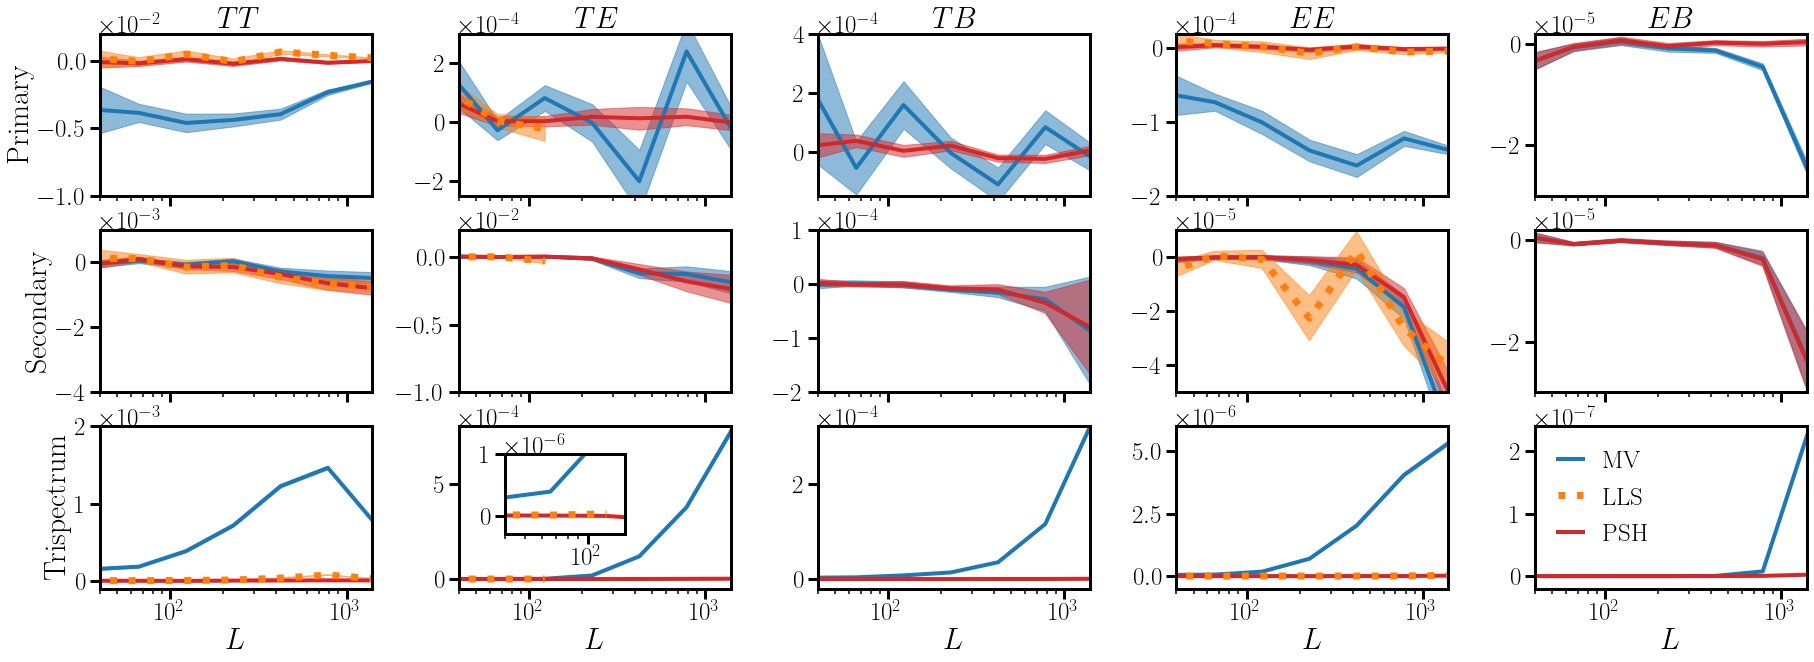

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,ax = plt.subplots(3,5,figsize=(25,9))

c_QE = 'C0'
c_LLS = 'C1'
c_PSH = 'C3'
lw = 4
lw2 = 7
alpha = 0.5



def ebar(i,j,c=c_QE,k=0,I=None):
    up = (data[i,j+k,:]+sdata[i,j+k,:])/Ckk
    down = (data[i,j+k,:]-sdata[i,j+k,:])/Ckk
    if I is not None: ax[j,i].fill_between(L[I],up[I],down[I],color=c,alpha=alpha)
    else: ax[j,i].fill_between(L,up,down,color=c,alpha=alpha)
        
    
##### TT
ax[0,0].semilogx(L,data[0,0,:]/Ckk,c=c_QE,lw=lw) ; ebar(0,0)
ax[1,0].semilogx(L,data[0,1,:]/Ckk,c=c_QE,lw=lw) ; ebar(0,1)
ax[2,0].semilogx(L,data[0,2,:]/Ckk,c=c_QE,lw=lw) ; ebar(0,2)

ax[0,0].semilogx(L,data[0,6,:]/Ckk,c=c_PSH,lw=lw) ; ebar(0,0,c=c_PSH,k=6) 
ax[1,0].semilogx(L,data[0,7,:]/Ckk,c=c_PSH,lw=lw) ; ebar(0,1,c=c_PSH,k=6) 
ax[2,0].semilogx(L,data[0,8,:]/Ckk,c=c_PSH,lw=lw) ; ebar(0,2,c=c_PSH,k=6)

ax[0,0].semilogx(L,data[0,3,:]/Ckk,c=c_LLS,lw=lw2,ls='dotted') ; ebar(0,0,c=c_LLS,k=3) 
ax[1,0].semilogx(L,data[0,4,:]/Ckk,c=c_LLS,lw=lw2,ls='dotted') ; ebar(0,1,c=c_LLS,k=3) 
ax[2,0].semilogx(L,data[0,5,:]/Ckk,c=c_LLS,lw=lw2,ls='dotted') ; ebar(0,2,c=c_LLS,k=3)    

##### TE
ax[0,1].semilogx(L,data[1,0,:]/Ckk,c=c_QE,lw=lw) ; ebar(1,0)
ax[1,1].semilogx(L,data[1,1,:]/Ckk,c=c_QE,lw=lw) ; ebar(1,1)
ax[2,1].semilogx(L,data[1,2,:]/Ckk,c=c_QE,lw=lw) ; ebar(1,2)

ax[0,1].semilogx(L,data[1,6,:]/Ckk,c=c_PSH,lw=lw) ; ebar(1,0,c=c_PSH,k=6) 
ax[1,1].semilogx(L,data[1,7,:]/Ckk,c=c_PSH,lw=lw) ; ebar(1,1,c=c_PSH,k=6) 
ax[2,1].semilogx(L,data[1,8,:]/Ckk,c=c_PSH,lw=lw) ; ebar(1,2,c=c_PSH,k=6) 

I = np.where(L < 150)
ax[0,1].semilogx(L[I],data[1,3,:][I]/Ckk[I],c=c_LLS,lw=lw2,ls='dotted') ; ebar(1,0,c=c_LLS,k=3,I=I)  
ax[1,1].semilogx(L[I],data[1,4,:][I]/Ckk[I],c=c_LLS,lw=lw2,ls='dotted') ; ebar(1,1,c=c_LLS,k=3,I=I)
ax[2,1].semilogx(L[I],data[1,5,:][I]/Ckk[I],c=c_LLS,lw=lw2,ls='dotted') ; ebar(1,2,c=c_LLS,k=3,I=I) 

inset = inset_axes(ax[2,1],width="40%",height="40%",bbox_to_anchor=(330,13,300,200))#,loc='upper center')
inset.semilogx(L,data[1,2,:]/Ckk,c=c_QE,lw=lw)
inset.semilogx(L,data[1,8,:]/Ckk,c=c_PSH,lw=lw)
inset.semilogx(L[I],data[1,5,:][I]/Ckk[I],c=c_LLS,lw=lw2,ls='dotted')
inset.set_xlim(40,150)
inset.set_ylim(-3e-7,1e-6)
inset.set_xticks([40,50,60,70,80,90],minor=True)
inset.set_xticklabels(['','','','','',''],minor=True)
inset.set_xticks([100])
inset.set_xticklabels([r'$10^2$'])

##### TB
ax[0,2].semilogx(L,data[2,0,:]/Ckk,c=c_QE,lw=lw) ; ebar(2,0)
ax[1,2].semilogx(L,data[2,1,:]/Ckk,c=c_QE,lw=lw) ; ebar(2,1)
ax[2,2].semilogx(L,data[2,2,:]/Ckk,c=c_QE,lw=lw) ; ebar(2,2)

ax[0,2].semilogx(L,data[2,6,:]/Ckk,c=c_PSH,lw=lw) ; ebar(2,0,c=c_PSH,k=6) 
ax[1,2].semilogx(L,data[2,7,:]/Ckk,c=c_PSH,lw=lw) ; ebar(2,1,c=c_PSH,k=6) 
ax[2,2].semilogx(L,data[2,8,:]/Ckk,c=c_PSH,lw=lw) ; ebar(2,2,c=c_PSH,k=6)  

##### EE
ax[0,3].semilogx(L,data[3,0,:]/Ckk,c=c_QE,lw=lw) ; ebar(3,0)
ax[1,3].semilogx(L,data[3,1,:]/Ckk,c=c_QE,lw=lw) ; ebar(3,1)
ax[2,3].semilogx(L,data[3,2,:]/Ckk,c=c_QE,lw=lw) ; ebar(3,2)

ax[0,3].semilogx(L,data[3,6,:]/Ckk,c=c_PSH,lw=lw) ; ebar(3,0,c=c_PSH,k=6) 
ax[1,3].semilogx(L,data[3,7,:]/Ckk,c=c_PSH,lw=lw) ; ebar(3,1,c=c_PSH,k=6) 
ax[2,3].semilogx(L,data[3,8,:]/Ckk,c=c_PSH,lw=lw) ; ebar(3,2,c=c_PSH,k=6) 

ax[0,3].semilogx(L,data[3,3,:]/Ckk,c=c_LLS,lw=lw2,ls='dotted') ; ebar(3,0,c=c_LLS,k=3) 
ax[1,3].semilogx(L,data[3,4,:]/Ckk,c=c_LLS,lw=lw2,ls='dotted') ; ebar(3,1,c=c_LLS,k=3)
ax[2,3].semilogx(L,data[3,5,:]/Ckk,c=c_LLS,lw=lw2,ls='dotted') ; ebar(3,2,c=c_LLS,k=3) 

##### EB
ax[0,4].semilogx(L,data[4,0,:]/Ckk,c=c_QE,lw=lw) ; ebar(4,0)
ax[1,4].semilogx(L,data[4,1,:]/Ckk,c=c_QE,lw=lw) ; ebar(4,1)
ax[2,4].semilogx(L,data[4,2,:]/Ckk,c=c_QE,lw=lw) ; ebar(4,2)

ax[0,4].semilogx(L,data[4,6,:]/Ckk,c=c_PSH,lw=lw) ; ebar(4,0,c=c_PSH,k=6) 
ax[1,4].semilogx(L,data[4,7,:]/Ckk,c=c_PSH,lw=lw) ; ebar(4,1,c=c_PSH,k=6) 
ax[2,4].semilogx(L,data[4,8,:]/Ckk,c=c_PSH,lw=lw) ; ebar(4,2,c=c_PSH,k=6)  

ax[0,0].set_ylabel('Primary')
ax[1,0].set_ylabel('Secondary')
ax[2,0].set_ylabel('Trispectrum')

for i in range(5): 
    ax[2,i].set_xlabel(r'$L$')
    ax[1,i].set_xticklabels([])
    ax[0,i].set_xticklabels([])
    ax[0,i].set_xlim(40,1400) ; ax[1,i].set_xlim(40,1400); ax[2,i].set_xlim(40,1400)
    ax[0,i].set_title(np.array([r'$TT$',r'$TE$',r'$TB$',r'$EE$',r'$EB$'])[i])
    for j in range(3):
        ax[j,i].ticklabel_format(style='sci',axis='y',scilimits=(-1,1))
        ax[j,i].yaxis.major.formatter._useMathText = True
        

ax[2,-1].plot([],[],lw=lw,c=c_QE,label=r'MV')    
ax[2,-1].plot([],[],lw=lw2,c=c_LLS,label=r'LLS',ls='dotted') 
ax[2,-1].plot([],[],lw=lw,c=c_PSH,label=r'PSH')
ax[2,-1].legend(loc='upper left',handlelength=1,ncol=1,frameon=False)

ax[0,0].set_ylim(-1e-2,0.2e-2) 
ax[1,0].set_ylim(-4e-3,1e-3) 
ax[2,0].set_ylim(-0.1e-3,2e-3)  

ax[0,1].set_ylim(-2.5e-4,3e-4)  
ax[1,1].set_ylim(-10e-3,2e-3)     
ax[2,1].set_ylim(-0.5e-4,8e-4)    

ax[0,2].set_ylim(-1.5e-4,4e-4)    
ax[1,2].set_ylim(-2e-4,1e-4)       
ax[2,2].set_ylim(-0.2e-4,3.2e-4)   

ax[0,3].set_ylim(-2e-4,0.2e-4)   
ax[1,3].set_ylim(-5e-5,1e-5)        
ax[2,3].set_ylim(-0.5e-6,6e-6)   

ax[0,4].set_ylim(-3e-5,0.2e-5)  
ax[1,4].set_ylim(-3e-5,0.2e-5)    
ax[2,4].set_ylim(-2e-8,24e-8)       


plt.tight_layout(pad=0.,w_pad=1.1,h_pad=0)
plt.savefig('biases.pdf',bbox_inches='tight')  

In [34]:
bin_edges = np.logspace(np.log10(25),np.log10(3.5e3),9)
LL,__ = get_norm_XY(fTT,FLLS_TT,Tmask,Tmask)
dlnLL = np.log(LL[1]) - np.log(LL[0])

def tmpfn(N,Lmin,Lmax):
    Ckk = p2d_cmblens.fPinterp(LL)
    integrand = np.nan_to_num(LL**2*dlnLL*Ckk**2 / (Ckk + N)**2)
    res = 1/np.sqrt(np.sum(integrand * (LL >= Lmin) * (LL <= Lmax)  ))
    return res

def tmpfn2(N,Lmin,Lmax,i):
    Ckk = p2d_cmblens.fPinterp(LL)
    total = interp1d(L,np.mean(datas[:,i,0,:] + datas[:,i,1,:] + datas[:,i,2,:],axis=0),bounds_error=False,fill_value=0)(LL)
    integrand1 = np.nan_to_num(LL**2*dlnLL*Ckk*total / (Ckk + N)**2)
    integrand2 = np.nan_to_num(LL**2*dlnLL*Ckk**2 / (Ckk + N)**2)
    int1 = np.sum(integrand1 * (LL >= Lmin) * (LL <= Lmax)  )
    int2 = np.sum(integrand2 * (LL >= Lmin) * (LL <= Lmax)  )
    return np.abs(int1/int2)

def get_errors(N = NormQE_TT):
    ees = []
    bbs = []
    for i in range(len(bin_edges)-1):
        res = tmpfn(N,bin_edges[i],bin_edges[i+1])
        ees.append(res)
        ees.append(res)
        bbs.append(bin_edges[i])
        bbs.append(bin_edges[i+1])
    return bbs,ees

/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


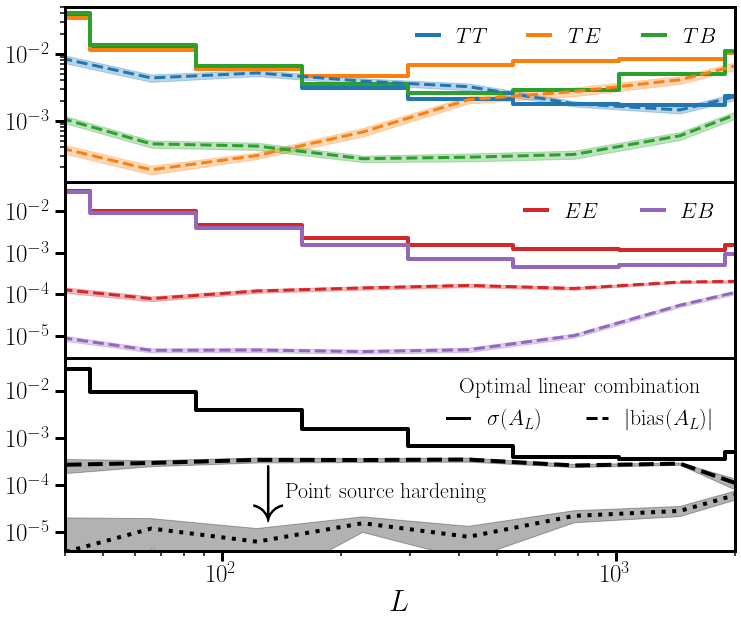

In [118]:
fig,ax = plt.subplots(3,1,figsize=(12,10),sharex=True,gridspec_kw={'height_ratios': [1,1,1.1],'hspace':0})

def get_totals(i):
    total = np.abs(datas[:,i,0,:] + datas[:,i,1,:] + datas[:,i,2,:])
    return np.mean(total,axis=0),np.std(total,axis=0)/np.sqrt(len(datas))

bbs,ees = get_errors(NormQE_TT)
ax[0].loglog(bbs,ees,c='C0',lw=4,label=r'$TT$')

bbs,ees = get_errors(NormQE_TE)
ax[0].loglog(bbs,ees,c='C1',lw=4,label=r'$TE$')

bbs,ees = get_errors(NormQE_TB)
ax[0].loglog(bbs,ees,c='C2',lw=4,label=r'$TB$')

bbs,ees = get_errors(NormQE_EE)
ax[1].loglog(bbs,ees,c='C3',lw=4,label=r'$EE$')

bbs,ees = get_errors(NormQE_EB)
ax[1].loglog(bbs,ees,c='C4',lw=4,label=r'$EB$')

for i in range(3):
    m,s = get_totals(i)
    ax[0].semilogx(L,m/Ckk,c='C'+str(i),lw=3,ls='--')
    ax[0].fill_between(L,(m-s)/Ckk,(m+s)/Ckk,color='C'+str(i),alpha=0.3)
    
for i in range(3,5):
    m,s = get_totals(i)
    ax[1].semilogx(L,m/Ckk,c='C'+str(i),lw=3,ls='--')
    ax[1].fill_between(L,(m-s)/Ckk,(m+s)/Ckk,color='C'+str(i),alpha=0.3)
    
bbs,ees = get_errors(noise_all) 
ax[2].loglog(bbs,ees,c='k',lw=4)
ax[2].loglog(L,data_comb[0,:]/Ckk,c='k',lw=4,ls='--')
ax[2].fill_between(L,(data_comb[0,:]+sdata_comb[0,:])/Ckk,(data_comb[0,:]-sdata_comb[0,:])/Ckk,color='k',alpha=0.3)
ax[2].loglog(L,data_comb[1,:]/Ckk,c='k',lw=4,ls='dotted')
ax[2].fill_between(L,(data_comb[1,:]+sdata_comb[1,:])/Ckk,(data_comb[1,:]-sdata_comb[1,:])/Ckk,color='k',alpha=0.3)

ax[2].plot([],[],c='k',lw=3,label=r'$\sigma(A_L)$')
ax[2].plot([],[],c='k',lw=3,ls='--',label=r'$|\text{bias}(A_L)|$')
    
ax[0].legend(loc='upper right',frameon=False,fontsize=22,handlelength=1,ncol=3)
ax[1].legend(loc='upper right',frameon=False,fontsize=22,handlelength=1,ncol=2)
ax[2].legend(loc='upper right',frameon=False,fontsize=22,handlelength=1,ncol=2,title='Optimal linear combination')
ax[0].set_xlim(40,2000)
ax[0].set_ylim(1.2e-4,5e-2) ; ax[1].set_ylim(3e-6,5e-2)
ax[2].set_ylim(4e-6,5e-2)
ax[2].set_xlabel(r'$L$')


ax[1].set_yticks([1e-5,1e-4,1e-3,1e-2])
ax[2].set_yticks([1e-5,1e-4,1e-3,1e-2])

ax[2].text(120,2.9e-5,r'$\downarrow$',fontsize=65)
ax[2].text(145,5e-5,r'Point source hardening')

plt.savefig('bias_and_noise.pdf',bbox_inches='tight')

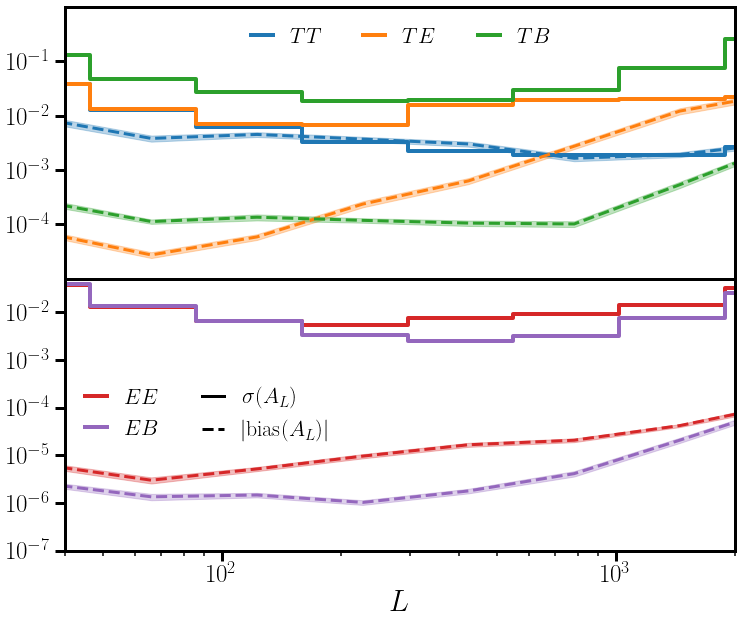

In [50]:
fig,ax = plt.subplots(2,1,figsize=(12,10),sharex=True,gridspec_kw={'height_ratios': [1,1],'hspace':0})

def get_totals(i):
    total = np.abs(datas[:,i,0,:] + datas[:,i,1,:] + datas[:,i,2,:])
    return np.mean(total,axis=0),np.std(total,axis=0)/np.sqrt(len(datas))

bbs,ees = get_errors(NormQE_TT)
ax[0].loglog(bbs,ees,c='C0',lw=4,label=r'$TT$')

bbs,ees = get_errors(NormQE_TE)
ax[0].loglog(bbs,ees,c='C1',lw=4,label=r'$TE$')

bbs,ees = get_errors(NormQE_TB)
ax[0].loglog(bbs,ees,c='C2',lw=4,label=r'$TB$')

bbs,ees = get_errors(NormQE_EE)
ax[1].loglog(bbs,ees,c='C3',lw=4,label=r'$EE$')

bbs,ees = get_errors(NormQE_EB)
ax[1].loglog(bbs,ees,c='C4',lw=4,label=r'$EB$')

for i in range(3):
    m,s = get_totals(i)
    ax[0].semilogx(L,m/Ckk,c='C'+str(i),lw=3,ls='--')
    ax[0].fill_between(L,(m-s)/Ckk,(m+s)/Ckk,color='C'+str(i),alpha=0.3)
    
for i in range(3,5):
    m,s = get_totals(i)
    ax[1].semilogx(L,m/Ckk,c='C'+str(i),lw=3,ls='--')
    ax[1].fill_between(L,(m-s)/Ckk,(m+s)/Ckk,color='C'+str(i),alpha=0.3)
    
#bbs,ees = get_errors(noise_all) 
#ax[2].loglog(bbs,ees,c='k',lw=4)
#ax[2].loglog(L,data_comb[0,:]/Ckk,c='k',lw=4,ls='--')
#ax[2].fill_between(L,(data_comb[0,:]+sdata_comb[0,:])/Ckk,(data_comb[0,:]-sdata_comb[0,:])/Ckk,color='k',alpha=0.3)
#ax[2].loglog(L,data_comb[1,:]/Ckk,c='k',lw=4,ls='dotted')
#ax[2].fill_between(L,(data_comb[1,:]+sdata_comb[1,:])/Ckk,(data_comb[1,:]-sdata_comb[1,:])/Ckk,color='k',alpha=0.3)

ax[1].plot([],[],c='k',lw=3,label=r'$\sigma(A_L)$')
ax[1].plot([],[],c='k',lw=3,ls='--',label=r'$|\text{bias}(A_L)|$')
    
ax[0].legend(loc='upper center',frameon=False,fontsize=22,handlelength=1,ncol=3)
ax[1].legend(loc='center left',frameon=False,fontsize=22,handlelength=1,ncol=2)
#ax[2].legend(loc='upper right',frameon=False,fontsize=22,handlelength=1,ncol=2,title='Optimal linear combination')
ax[0].set_xlim(40,2000)
ax[0].set_ylim(1e-5,1) ; ax[1].set_ylim(1e-7,5e-2)
#ax[2].set_ylim(4e-6,5e-2)
ax[1].set_xlabel(r'$L$')


ax[0].set_yticks([1e-4,1e-3,1e-2,1e-1])
ax[1].set_yticks([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2])

#ax[2].text(120,2.9e-5,r'$\downarrow$',fontsize=65)
#ax[2].text(145,5e-5,r'Point source hardening')

plt.savefig('bias_and_noise_SO.pdf',bbox_inches='tight')

# Poisson vs Gaussian sources

In [12]:
from random import randint

def create_random_source_map(N=100,r=3):
    result = np.zeros((512,512))
    def paint_circle(x,y):
        try: 
            result[x,y] = 1
        except:
            pass
        for i in range(-r,r):
            for j in range(-r,r):
                if (i**2 + j**2)**0.5 <= r:
                    try:
                        result[x+i,y+j] = 1
                    except:
                        pass
    for i in range(N):
        x = randint(0,512)
        y = randint(0,512)
        paint_circle(x,y)
    return result

In [13]:
source_map = create_random_source_map(N=1000,r=0)
smap = enmap.ndmap(source_map,wcs)

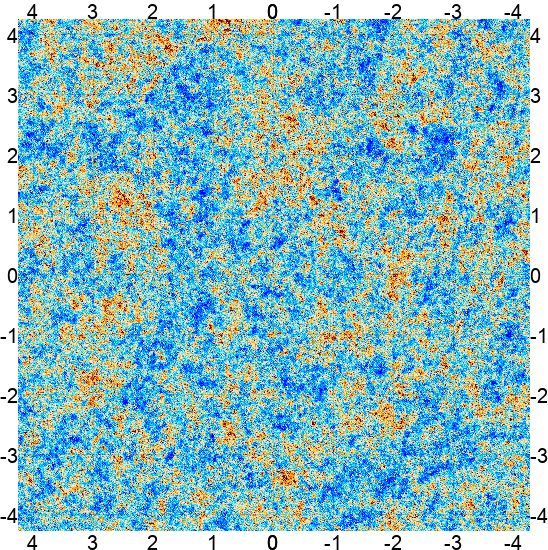

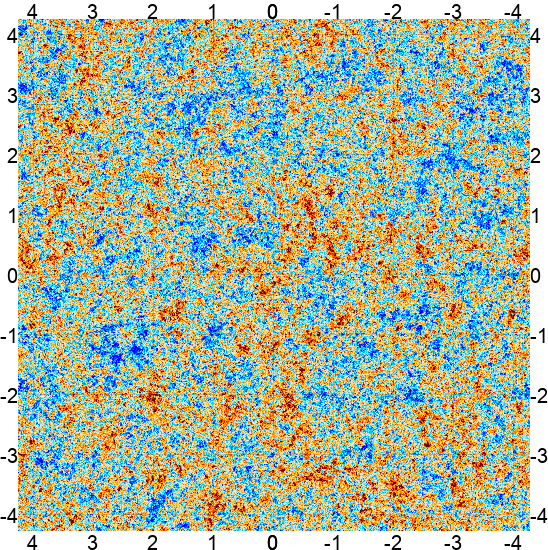

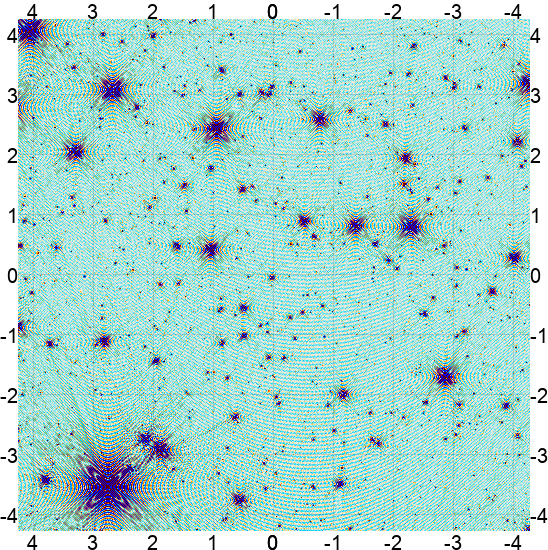

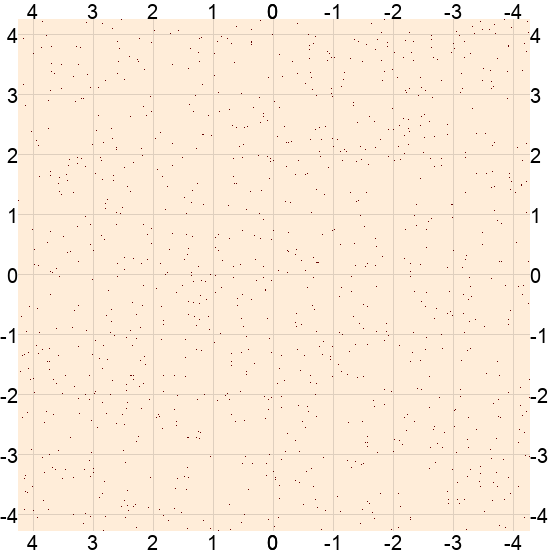

In [14]:
# question 1) the scale doesn't seem to be right?

from pixell import enplot

plots = enplot.plot(ikmap, enmap.ndmap(kCmb,wcs) , ismap, smap)

enplot.show(plots)

<ipython-input-371-be20aaa07947>:10: RuntimeWarning: invalid value encountered in true_divide
  result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]


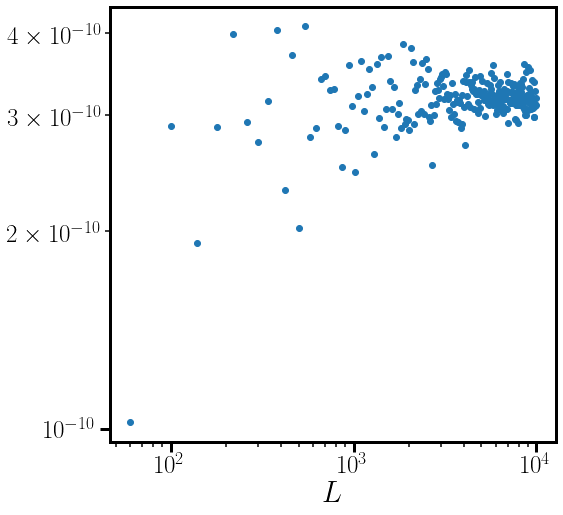

In [371]:
# despite the scale not looking correct, the power spectra of the two maps are identical??

plt.figure(figsize=(8,8))

ikmapFourier = enmap.fft(smap,normalize='phys')
power = (ikmapFourier*np.conj(ikmapFourier)).real

def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return result

bin_edges = np.arange(0,10000,40)
centers = (bin_edges[1:] + bin_edges[:-1])/2.
binned_power = bin(power,power.modlmap(),bin_edges)


plt.loglog(centers,binned_power,marker="o",ls="none")
plt.xlabel(r'$L$')
plt.show()

In [373]:
smooth_scale=2000
smooth = np.exp(-(ikmap.modlmap()/smooth_scale)**2)

def reconstruct_kappa_on_sources(FTT=FQE_TT,gaus=False):
    source_map = create_random_source_map(N=1000,r=0)
    smap = enmap.ndmap(source_map,wcs)
    if gaus:
        smapFourier = baseMap.genGRF(lambda l: l*0 + 3e-10)
        smap = enmap.ndmap(baseMap.inverseFourier(smapFourier),wcs )
    
    lSFourier = enmap.fft(smap, normalize='phys')
    feed_dict['X'] = lSFourier
    nonnorm_kappa = Acorr * fac.integrate(shape,wcs,feed_dict,FTT*fac.e('X_l1')*fac.e('X_l2'),
                                          xmask=Tmask,ymask=Tmask,physical_units=False)
    
    invnorm = invnorm = Acorr * fac.integrate(shape,wcs,feed_dict,FTT*fTT,
                                              xmask=Tmask,ymask=Tmask,physical_units=False)
    invnorm[0,0] = invnorm[0,1]
    return enmap.ifft(nonnorm_kappa * smooth / invnorm / 2 / np.pi, normalize='phys').real

In [374]:
kss_QE = []
kgg_QE = []
kss_LLS = []
kgg_LLS = []

In [375]:
for i in range(100): 
    kss_QE.append(reconstruct_kappa_on_sources())
    kgg_QE.append(reconstruct_kappa_on_sources(gaus=True))
    kss_LLS.append(reconstruct_kappa_on_sources(FTT=FLLS_TT))
    kgg_LLS.append(reconstruct_kappa_on_sources(FTT=FLLS_TT,gaus=True))

In [376]:
# do some averaging
kss_QE_avg = kss_QE[0]
kgg_QE_avg = kgg_QE[0]
kss_LLS_avg = kss_LLS[0]
kgg_LLS_avg = kgg_LLS[0]
for i in range(1,len(kss_QE)): 
    kss_QE_avg += kss_QE[i]
    kgg_QE_avg += kgg_QE[i]
    kss_LLS_avg += kss_LLS[i]
    kgg_LLS_avg += kgg_LLS[i]
kss_QE_avg /= len(kss_QE)
kgg_QE_avg /= len(kgg_QE)
kss_LLS_avg /= len(kss_LLS)
kgg_LLS_avg /= len(kgg_LLS)

In [377]:
stuff = Acorr * fac.integrate(shape,wcs,feed_dict,2*FQE_TT**2,xmask=Tmask,ymask=Tmask,physical_units=False).real
L,thisshit = binner.bin(stuff)
QE_theory = thisshit * NormQE_TT**2

/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [378]:
stuff = Acorr * fac.integrate(shape,wcs,feed_dict,FLLS_TT*(FLLS_TT + swap_12(FLLS_TT)),xmask=Tmask,ymask=Tmask,physical_units=False).real
L,thisshit = binner.bin(stuff)
LLS_theory = thisshit * NormLLS_TT**2

/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [331]:
stuff = Acorr * fac.integrate(shape,wcs,feed_dict,FQE_TT,xmask=Tmask,ymask=Tmask,physical_units=False).real
L,thisshit = binner.bin(stuff)
QE_other_theory = thisshit**2 * NormQE_TT**2

/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [333]:
stuff = Acorr * fac.integrate(shape,wcs,feed_dict,FLLS_TT,xmask=Tmask,ymask=Tmask,physical_units=False).real
L,thisshit = binner.bin(stuff)
LLS_other_theory = thisshit**2 * NormLLS_TT**2

/home/noah/Berkeley/LensQuEst-1/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


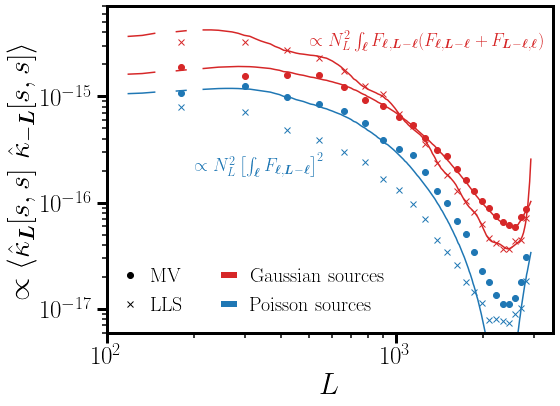

In [460]:
plt.figure(figsize=(8,6))

ikmapFourier = enmap.fft(kss_QE_avg,normalize='phys')
power = (ikmapFourier*np.conj(ikmapFourier)).real

ikmapFourier = enmap.fft(kgg_QE_avg,normalize='phys')
power2 = (ikmapFourier*np.conj(ikmapFourier)).real

ikmapFourier = enmap.fft(kss_LLS_avg,normalize='phys')
power3 = (ikmapFourier*np.conj(ikmapFourier)).real

ikmapFourier = enmap.fft(kgg_LLS_avg,normalize='phys')
power4 = (ikmapFourier*np.conj(ikmapFourier)).real

def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return result

bin_edges = np.arange(0,3000,120)
centers = (bin_edges[1:] + bin_edges[:-1])/2.
binned_power = bin(power/smooth**2,power.modlmap(),bin_edges)
binned_power2 = bin(power2/smooth**2,power2.modlmap(),bin_edges)
binned_power3 = bin(power3/smooth**2,power2.modlmap(),bin_edges)
binned_power4 = bin(power4/smooth**2,power2.modlmap(),bin_edges)


plt.loglog(centers,binned_power * 1e4,marker="o",ls="none",c='C0')
plt.loglog(centers,binned_power2 * (1.6)**4* 1e4,marker="o",ls="none",c='C3')
plt.loglog(centers,binned_power3* 1e4,marker="x",ls="none",c='C0')
plt.loglog(centers,binned_power4 * (1.6)**4* 1e4,marker="x",ls="none",c='C3')


plt.loglog([],[],marker="o",ls="none",label=r'MV',c='k')
plt.loglog([],[],marker="x",ls="none",label=r'LLS',c='k')
plt.loglog([],[],ls="-",label=r'Gaussian sources',c='C3',lw=6)
plt.loglog([],[],ls="-",label=r'Poisson sources',c='C0',lw=6)

I = np.where(L < 2930)

plt.loglog(L[I],QE_theory[I]/15e15,c='C3',zorder=-1)
plt.loglog(L[I],LLS_theory[I]/15e15,c='C3',zorder=-1)

plt.loglog(L[I],QE_other_theory[I]/3e21,c='C0',zorder=-1)
#plt.loglog(L[I],LLS_other_theory[I]/3e20,c='C0',zorder=-1)

plt.legend(loc='lower left',frameon=False,fontsize=20,handlelength=0.5,ncol=2)
plt.xlabel(r'$L$')
plt.ylabel(r'$\propto \langle \hat{\kappa}_{\boldsymbol{L}}[s,s]\,\,$'+
                r'$\hat{\kappa}_{-\boldsymbol{L}}[s,s]\rangle$')

plt.text(500,3e-15,r'$\propto N^2_L \int_{\boldsymbol{\ell}} F_{\boldsymbol{\ell},\boldsymbol{L}-\boldsymbol{\ell}} (F_{\boldsymbol{\ell},\boldsymbol{L}-\boldsymbol{\ell}} + F_{\boldsymbol{L}-\boldsymbol{\ell},\boldsymbol{\ell}}) $',fontsize=18,color='C3')
plt.text(200,2e-16,r'$\propto N^2_L \left[\int_{\boldsymbol{\ell}} F_{\boldsymbol{\ell},\boldsymbol{L}-\boldsymbol{\ell}}\right]^2$',fontsize=18,color='C0')


plt.ylim(6e-18,7e-15)
plt.xlim(100,3.5e3)
plt.show()

<ipython-input-200-19d2daf14c27>:12: RuntimeWarning: invalid value encountered in true_divide
  result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
<ipython-input-200-19d2daf14c27>:12: RuntimeWarning: invalid value encountered in true_divide
  result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]


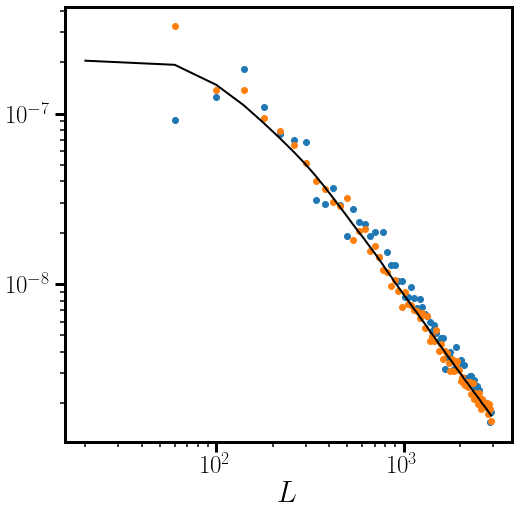

In [200]:
# despite the scale not looking correct, the power spectra of the two maps are identical??

plt.figure(figsize=(8,8))

ikmapFourier = enmap.fft(ikmap,normalize='phys')
ikmap2Fourier = enmap.fft(enmap.ndmap(kCmb,wcs) ,normalize='phys')
power = (ikmapFourier*np.conj(ikmapFourier)).real
power2 = (ikmap2Fourier*np.conj(ikmap2Fourier)).real

def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return result

bin_edges = np.arange(0,3000,40)
centers = (bin_edges[1:] + bin_edges[:-1])/2.
binned_power = bin(power,power.modlmap(),bin_edges)
binned_power2 = bin(power2,power2.modlmap(),bin_edges)


plt.loglog(centers,binned_power,marker="o",ls="none")
plt.loglog(centers,binned_power2,marker="o",ls="none")
plt.loglog(centers,p2d_cmblens.fPinterp(centers),lw=2,c='k')
plt.xlabel(r'$L$')
plt.show()

In [149]:
# let's mass produce some kappa maps


# I clearly don't understand the normalization of these FFTs... 7 must be 2 pi

smooth_scale=2000
smooth = np.exp(-(ikmap.modlmap()/smooth_scale)**2)

def reconstruct_kappa():
    # get random unlensed CMB
    cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
    cmb0 = baseMap.inverseFourier(cmb0Fourier)
    # lens the CMB using the Websky kappa
    lCmb_ = baseMap.doLensing(unlensed=cmb0,kappaFourier=baseMap.fourier(ikmap[0]))
    lCmb = enmap.ndmap(lCmb_,wcs)
    lCmbFourier = enmap.fft(lCmb, normalize='phys')
    feed_dict['X'] = lCmbFourier
    nonnorm_kappa = Acorr * fac.integrate(shape,wcs,feed_dict,FQE_TT*fac.e('X_l1')*fac.e('X_l2'),
                                          xmask=Tmask,ymask=Tmask,physical_units=False)
    
    invnorm = invnorm = Acorr * fac.integrate(shape,wcs,feed_dict,FQE_TT*fTT,
                                              xmask=Tmask,ymask=Tmask,physical_units=False)
    invnorm[0,0] = invnorm[0,1]
    
    return enmap.ifft(nonnorm_kappa * smooth / invnorm / 2 / np.pi, normalize='phys').real

In [150]:
kappas = []

In [164]:
for i in range(50): kappas.append(reconstruct_kappa())

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x

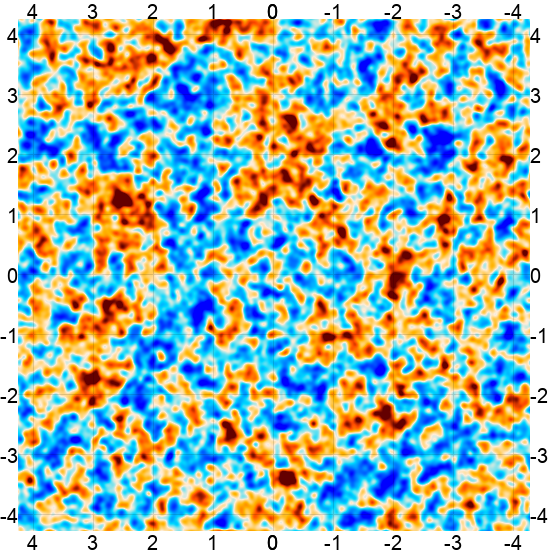

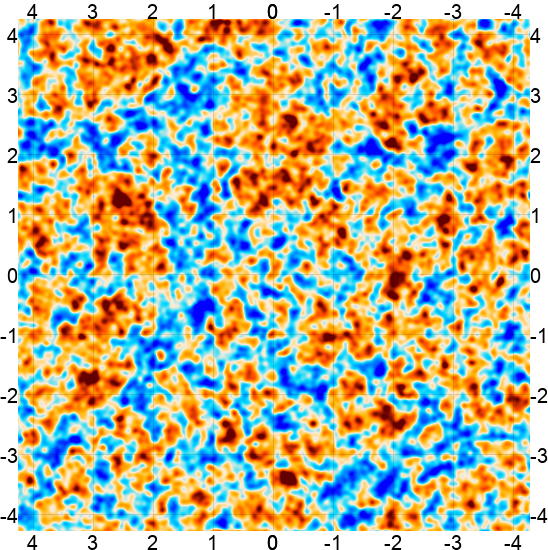

In [163]:
#### average of reconstructed maps
kappa_avg = kappas[0]
for i in range(1,len(kappas)): kappa_avg += kappas[i]
kappa_avg /= len(kappas)
####

#### smoothed input kappa map
ikmapFourier = enmap.fft(ikmap,normalize='phys')
ikmapSmooth = enmap.ifft(ikmapFourier * smooth * (1+0j), normalize='phys').real
####

plots = enplot.plot(ikmapSmooth,kappa_avg)

enplot.show(plots)

<ipython-input-165-0ca518596a0b>:10: RuntimeWarning: invalid value encountered in true_divide
  result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
<ipython-input-165-0ca518596a0b>:10: RuntimeWarning: invalid value encountered in true_divide
  result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]


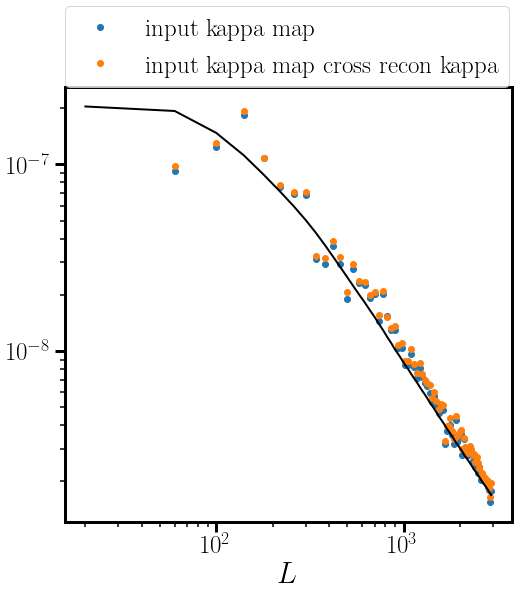

In [165]:
plt.figure(figsize=(8,8))

ikmapFourier = enmap.fft(ikmapSmooth,normalize='phys')
ikmap2Fourier = enmap.fft(kappa_avg ,normalize='phys')
power = (ikmapFourier*np.conj(ikmapFourier)).real
power2 = (ikmap2Fourier*np.conj(ikmapFourier)).real

def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return result

bin_edges = np.arange(0,3000,40)
centers = (bin_edges[1:] + bin_edges[:-1])/2.
binned_power = bin(power/smooth**2,power.modlmap(),bin_edges)
binned_power2 = bin(power2/smooth**2,power2.modlmap(),bin_edges)


plt.loglog(centers,binned_power,marker="o",ls="none",label=r'input kappa map')
plt.loglog(centers,binned_power2,marker="o",ls="none",label=r'input kappa map cross recon kappa')
plt.loglog(centers,p2d_cmblens.fPinterp(centers),lw=2,c='k')
plt.xlabel(r'$L$')
plt.legend(loc=(0,1))
plt.show()

#  -------------------------- OLD STUFF --------------------------------------

In [ ]:
# Manu's code to get an unlensed CMB map and kappa map


# number of pixels for the flat map
nX = 512
nY = 512
# map dimensions in degrees
sizeX = 512 / 60 
sizeY = 512 / 60 
# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)
# generate CMB map
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)
# generate kappa
kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)

# load the websky kappa and radio point source maps
from pixell import reproject
fname = 'kap.fits'
ikmap = reproject.enmap_from_healpix(fname, shape, wcs, ncomp=1, unit=1, lmax=16000,rot="gal,equ")
fname = 'map_healpix_4096_f153.0.fits'
ismap = reproject.enmap_from_healpix(fname, shape, wcs, ncomp=1, unit=1, lmax=16000,rot="gal,equ")


shape2,wcs2 = enmap.geometry(shape=(512,512),res=np.deg2rad(1./60),pos=(0.01,0))

fname = 'map_healpix_4096_f153.0.fits'
ismap = reproject.enmap_from_healpix(fname, shape, wcs, ncomp=1, unit=1, lmax=20000,rot="gal,equ")
ismap2 = reproject.enmap_from_healpix(fname, shape2, wcs2, ncomp=1, unit=1, lmax=20000,rot="gal,equ")

In [ ]:
cutoutFourier = enmap.fft(cutout)
lx,ly = cutout.lmap()
l = cutout.modlmap()
phi = np.zeros(cutout.shape)
for i in range(cutout.shape[0]):
    for j in range(cutout.shape[1]):
        if l[i,j] > 0: phi[i,j] = get_angle( np.array([lx[i,j],ly[i,j]]) )
            
cutout_E_plus_iB_fourier = - enmap.fft((cutout_Q+cutout_U*1j)*np.exp(- 2*1j*phi))
cutout_E_plus_iB = enmap.ifft(cutout_E_plus_iB_fourier)
cutout_E_slow = cutout_E_plus_iB.real
cutout_B_slow = cutout_E_plus_iB.imag

# Create map from catalog (checked that this agrees with preexisting map)

In [ ]:
fname = 'catalog_153.0.h5'
fluxcut = 50000 # [Jy]

f = h5py.File(fname, 'r')
f_ra = np.array(f['phi']) 
I = np.where(f_ra > np.pi)
f_ra[I] -= 2*np.pi
f_dec = np.pi/2 - np.array(f['theta'])
f_flux = np.array(f['flux'])


I = np.where(np.abs(f_ra) < np.deg2rad(0.2))
ff_ra = f_ra[I]
ff_dec = f_dec[I]
ff_flux = f_flux[I]
I = np.where(np.abs(ff_dec) < np.deg2rad(0.2))
fff_ra = ff_ra[I]
fff_dec = ff_dec[I]
fff_flux = ff_flux[I]


full_map_153 = {}
full_map_153['dec'] = full_map_1res.posmap()[0]
full_map_153['ra'] = full_map_1res.posmap()[1]
full_map_153['flux'] = np.zeros((full_map_153['ra'].shape))

decs = full_map_153['dec'][:,0]
ras = full_map_153['ra'][0,:]

for i in range(len(fff_ra)):
    RA,DEC,FLUX = fff_ra[i],fff_dec[i],fff_flux[i]
    j = np.abs(decs - DEC).argmin()
    k = np.abs(ras - RA).argmin()
    if FLUX < fluxcut: full_map_153['flux'][j,k] += FLUX
        
        
full_map_153_ndmap = enmap.ndmap(full_map_153['flux'],full_map_1res.wcs)

dec,ra = np.deg2rad([0,0])
width = np.deg2rad(0.4)
box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]

cutout = full_map_1res.submap(box)
cutout_recon = full_map_153_ndmap.submap(box)


plots = enplot.plot(enmap.upgrade(cutout_recon,5),enmap.upgrade(cutout,5),mask=0)
enplot.show(plots)

In [ ]:
# power spectrum of cutout

plt.figure(figsize=(8,8))

ikmapTFourier = enmap.fft(cutout,normalize='phys')

powerTT = (ikmapTFourier*np.conj(ikmapTFourier)).real

def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    result = np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return result

bin_edges = np.arange(0,10000,40)
centers = (bin_edges[1:] + bin_edges[:-1])/2.
binned_powerTT = bin(powerTT,powerTT.modlmap(),bin_edges)

plt.loglog(centers,centers**2 * binned_powerTT/2/np.pi,marker="o",ls="none",label=r'$C^{TT}_\ell$')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell$ [$\mu$K$^2$]')
plt.show()

In [ ]:
# old plot showing only one panel

plt.figure(figsize=(8,8))
plt.loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=3)

plt.loglog(L,NormQE_TT,lw=2,c='C0',label=r'$TT$')
plt.loglog(L,NormQE_TE,lw=2,c='C1',label=r'$TE$')
plt.loglog(L,NormQE_TB,lw=2,c='C2',label=r'$TB$')
plt.loglog(L,NormQE_EE,lw=2,c='C3',label=r'$EE$')
plt.loglog(L,NormQE_EB,lw=2,c='C4',label=r'$EB$')

plt.loglog(L,NormQE_TT*NC_TT,lw=3,ls='--',c='C0')
plt.loglog(L,NormQE_TE*NC_TE,lw=3,ls='--',c='C1')
plt.loglog(L,NormQE_TB*NC_TB,lw=3,ls='--',c='C2')
plt.loglog(L,NormQE_EE*NC_EE,lw=3,ls='--',c='C3')
plt.loglog(L,NormQE_EB*NC_EB,lw=3,ls='--',c='C4')

plt.loglog(L,NormLLS_TT**2 * ucNoiseLLS_TT,lw=1.5,c='C0',ls='-.')
plt.loglog(L,NormLLS_TE**2 * ucNoiseLLS_TE,lw=1.5,c='C1',ls='-.')
plt.loglog(L,NormLLS_EE**2 * ucNoiseLLS_EE,lw=1.5,c='C3',ls='-.')

plt.loglog([],[],lw=3,c='white',ls='dotted',label=r'$ $')
plt.loglog([],[],lw=3,c='white',ls='dotted',label=r'$ $')
plt.loglog([],[],lw=1.5,c='k',ls='-.',label=r'LLS')
plt.loglog([],[],lw=3,c='k',ls='--',label=r'PSH')
plt.loglog([],[],lw=2,c='k',label=r'MV')

plt.xlim(10,6000)
plt.ylim(4e-9,5e-5)
plt.xlabel(r'$L$')
plt.ylabel(r'$\mathcal{N}^{XY}_{L}$')
plt.legend(loc='upper left',frameon=False,ncol=2,fontsize=20,handlelength=1)
plt.savefig('noise_curves.pdf',bbox_inches='tight')

In [ ]:
f_matrix_symlens = Matrix([[fEE,fEB],
                          [swap_12(fEB),0]])

C_l1_inv            = Matrix([[fac.e('tCinv_E_E_l1'),fac.e('tCinv_E_B_l1')],
                              [fac.e('tCinv_E_B_l1'),fac.e('tCinv_B_B_l1')]])

C_l2_inv            = Matrix([[fac.e('tCinv_E_E_l2'),fac.e('tCinv_E_B_l2')],
                              [fac.e('tCinv_E_B_l2'),fac.e('tCinv_B_B_l2')]])

#mask_matrix = Matrix([[fac.e('Pmask_l1')*fac.e('Pmask_l2'),fac.e('Pmask_l1')*fac.e('Pmask_l2')],
#                      [fac.e('Pmask_l1')*fac.e('Pmask_l2'),fac.e('Pmask_l1')*fac.e('Pmask_l2')]])

F_GMV_smpy = 0.5 * C_l1_inv * f_matrix_symlens * C_l2_inv

integrand = Trace(F_GMV_smpy * f_matrix_symlens.T).simplify()

result = fac.integrate(shape,wcs,feed_dict,integrand,xmask=Pmask,ymask=Pmask,physical_units=False).real
Norm_GMV_symlens_pol_only = 1/binner.bin(Acorr*result)[1]